Regional Grain size model, SE USA and E Australia combined

Dan Buscombe
PCMSC

7/6/2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import geopandas as gpd
from geopandas.tools import sjoin

read US data

In [2]:
# dfSEUS = pd.read_csv('../../../analysis/SEusa/model_data_out/ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat.csv')
dfSEUS = pd.read_csv('../model_data/ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects_model_stratsample-by-lat.csv')

In [123]:
len(dfSEUS)

270

create Aus data

In [664]:
# dataset = '../../../orig_data/australia/dataset_Australia_East_coast.geojson'

# dfOz = gpd.read_file(dataset)

# dfOz = dfOz[dfOz['d50']<=.9] #2
# len(dfOz)

# ind = np.where(dfOz['quality_flag']!='Low')[0]
# len(ind)
# dfOz = dfOz.iloc[ind]
# len(dfOz)

# ind = np.where(dfOz['distance_to_sample']<1000)[0]
# len(ind)
# dfOz = dfOz.iloc[ind]
# len(dfOz)

# dfOz = dfOz.dropna()
# # df.head()
# len(dfOz)

# dfOz.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
# dfOz.to_csv('../model_data/dataset_Australia_East_coast_nostrat.csv')

Read dataset

In [665]:
# dfEAus = pd.read_csv('../../../analysis/australia/model_data/dataset_Australia_East_coast_stratsample-by-lat.csv')
dfEAus = pd.read_csv('../model_data/dataset_Australia_East_coast_nostrat.csv')

In [666]:
len(dfEAus)

256

add code, 0=Oz, 1=US

In [235]:
dfSEUS['code'] = np.ones(len(dfSEUS))
dfEAus['code'] = np.zeros(len(dfEAus))

In [236]:
# dfSEUS.keys()

clip

In [237]:
dfSEUS = dfSEUS[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 'code',
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

In [238]:
dfEAus = dfEAus[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 'code',
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

merge datasets

In [239]:
df = pd.concat([dfSEUS, dfEAus], ignore_index=True)
df = df.dropna()
len(df)

526

In [240]:
print(np.sum(df.code==0))
print(np.sum(df.code==1))

256
270


In [241]:
df.keys()

Index(['latitude', 'longitude', 'd50', 'beach_slope_average', 'mstr', 'code',
       'hs_max', 'hs_mean', 'dir', 'tp'],
      dtype='object')

In [242]:
X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [243]:
Xoz = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy()[df['code']==0], columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [244]:
Xus = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy()[df['code']==1], columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

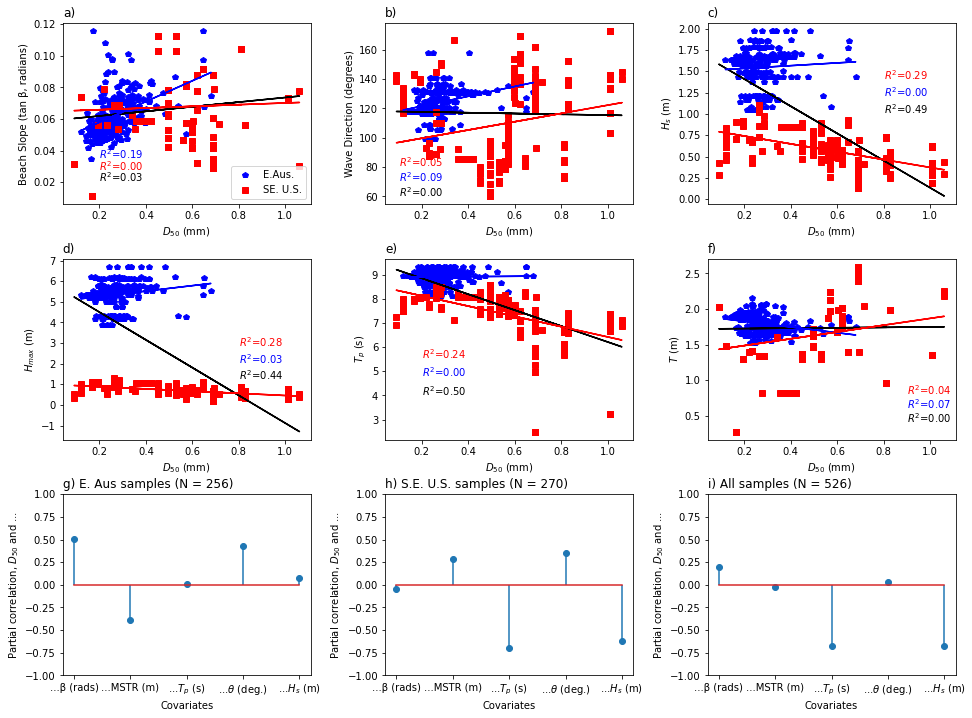

In [245]:
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#######################
plt.subplot(331)
plt.plot(df['d50'][df['code']==0], df['beach_slope_average'][df['code']==0],'bp', label='E.Aus.')
plt.plot(df['d50'][df['code']==1], df['beach_slope_average'][df['code']==1],'rs', label='SE. U.S.')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Beach Slope (tan β, radians)')
plt.title("a)", loc='left')
plt.legend(loc=4)

coef = np.polyfit(df['d50'], df['beach_slope_average'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['beach_slope_average']))**2
plt.text(.2,.02,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['beach_slope_average'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['beach_slope_average'][df['code']==0]))**2
plt.text(.2,.035,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['beach_slope_average'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['beach_slope_average'][df['code']==1]))**2
plt.text(.2,.027,r'$R^2$='+str(r2)[:4], color='r')

#######################
plt.subplot(332)
plt.plot(df['d50'][df['code']==0], df['dir'][df['code']==0],'bp')
plt.plot(df['d50'][df['code']==1], df['dir'][df['code']==1],'rs')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel('Wave Direction (degrees)')
plt.title("b)", loc='left')

coef = np.polyfit(df['d50'], df['dir'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['dir']))**2
plt.text(.1,60,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['dir'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['dir'][df['code']==0]))**2
plt.text(.1,70,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['dir'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['dir'][df['code']==1]))**2
plt.text(.1,80,r'$R^2$='+str(r2)[:4], color='r')

#######################
plt.subplot(333)
plt.plot(df['d50'][df['code']==0], df['hs_mean'][df['code']==0],'bp')
plt.plot(df['d50'][df['code']==1], df['hs_mean'][df['code']==1],'rs')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{s}$ (m)')
plt.title("c)", loc='left')

coef = np.polyfit(df['d50'], df['hs_mean'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_mean']))**2
plt.text(.8,1,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['hs_mean'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['hs_mean'][df['code']==0]))**2
plt.text(.8,1.2,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['hs_mean'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['hs_mean'][df['code']==1]))**2
plt.text(.8,1.4,r'$R^2$='+str(r2)[:4], color='r')

#######################
plt.subplot(334)
plt.plot(df['d50'][df['code']==0], df['hs_max'][df['code']==0],'bp')
plt.plot(df['d50'][df['code']==1], df['hs_max'][df['code']==1],'rs')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$H_{max}$ (m)')
plt.title("d)", loc='left')

coef = np.polyfit(df['d50'], df['hs_max'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['hs_max']))**2
plt.text(.8,1.2,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['hs_max'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['hs_max'][df['code']==0]))**2
plt.text(.8,2,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['hs_max'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['hs_max'][df['code']==1]))**2
plt.text(.8,2.8,r'$R^2$='+str(r2)[:4], color='r')

#######################
plt.subplot(335)
plt.plot(df['d50'][df['code']==0], df['tp'][df['code']==0],'bp')
plt.plot(df['d50'][df['code']==1], df['tp'][df['code']==1],'rs')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T_{p}$ (s)')
plt.title("e)", loc='left')

coef = np.polyfit(df['d50'], df['tp'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['tp']))**2
plt.text(.2,4,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['tp'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['tp'][df['code']==0]))**2
plt.text(.2,4.75,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['tp'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['tp'][df['code']==1]))**2
plt.text(.2,5.5,r'$R^2$='+str(r2)[:4], color='r')

#######################
plt.subplot(336)
plt.plot(df['d50'][df['code']==0],df['mstr'][df['code']==0] ,'bp')
plt.plot(df['d50'][df['code']==1],df['mstr'][df['code']==1] ,'rs')
plt.xlabel(r'$D_{50}$ (mm)')
plt.ylabel(r'$T$ (m)')
plt.title("f)", loc='left')

coef = np.polyfit(df['d50'], df['mstr'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')

r2 = np.min(np.corrcoef(df['d50'], df['mstr']))**2
plt.text(.9,.4,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(df['d50'][df['code']==0], df['mstr'][df['code']==0],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==0], poly1d_fn(df['d50'][df['code']==0]), '-b')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], df['mstr'][df['code']==0]))**2
plt.text(.9,.6,r'$R^2$='+str(r2)[:4], color='b')

coef = np.polyfit(df['d50'][df['code']==1], df['mstr'][df['code']==1],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'][df['code']==1], poly1d_fn(df['d50'][df['code']==1]), '-r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], df['mstr'][df['code']==1]))**2
plt.text(.9,.8,r'$R^2$='+str(r2)[:4], color='r')

#######################
ax = plt.subplot(337)
plt.stem(Xoz['r'])
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (rads)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"g) E. Aus samples (N = {})".format(len(df[df['code']==0])), loc='left')

#######################
ax = plt.subplot(338)
plt.stem(Xus['r'])
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (rads)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"h) S.E. U.S. samples (N = {})".format(len(df[df['code']==1])), loc='left')

#######################
ax = plt.subplot(339)
plt.stem(X['r'])
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (rads)','...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-1,1)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"i) All samples (N = {})".format(len(df)), loc='left')

plt.savefig('../data_plots/SEUS_EAus_d50-linreg-partcorrel-df_strat_lat.jpg', dpi=300, bbox_inches='tight')

In [246]:
def mcfall(X,hs):
    if hs<=1:
        A = 3.1; n = -1.1 
    elif hs>=3:
        A = 3.9; n = -1.85         
    else:
        A = 2.1; n = -1.8             
    return (X/A)**(1/n)

def bujan(B,a,b,c):
    t1=(B-c)
    return (1/8)*(8*((t1/a))**(1/b)+1)

def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

In [247]:
## baselines

In [248]:
ds_est_baseline = np.array([mcfall(X,hs) for X,hs in zip(1/df['beach_slope_average'],df['hs_mean'])])

a = -0.154
b = -0.145
c = 0.268

ds_est_baseline2 = np.array([bujan(B,a,b,c) for B in df['beach_slope_average']])

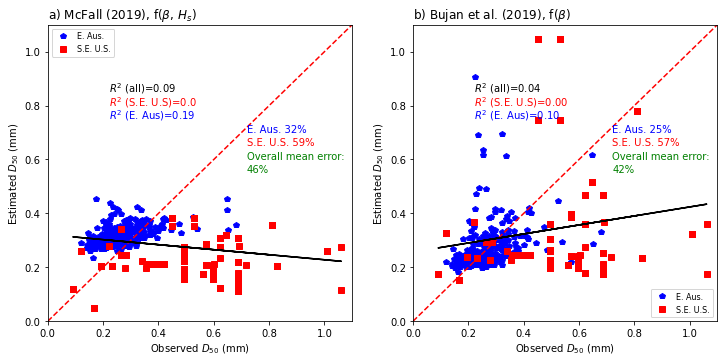

In [249]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(221)
plt.plot(df['d50'][df['code']==0], ds_est_baseline[df['code']==0], 'bp', label='E. Aus.')
plt.plot(df['d50'][df['code']==1], ds_est_baseline[df['code']==1], 'rs', label='S.E. U.S.')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) McFall (2019), f($\beta$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline))**2
plt.text(.22,.85,r'$R^2$ (all)='+str(r2)[:4], color='k')

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], ds_est_baseline[df['code']==1]))**2
r2=0.0
plt.text(.22,.8,r'$R^2$ (S.E. U.S)='+str(r2)[:4], color='r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], ds_est_baseline[df['code']==0]))**2
if r2>1:
    r2=0.0
plt.text(.22,.75,r'$R^2$ (E. Aus)='+str(r2)[:4], color='b')


coef = np.polyfit(df['d50'], ds_est_baseline,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')
plt.legend(fontsize=8)

plt.text(.72,.6, r'Overall mean error:', color='g')
plt.text(.72,.55, r'{}%'.format(str(np.mean(prc_err(df['d50'], ds_est_baseline)))[:2]), color='g')
plt.text(.72,.7, r'E. Aus. {}%'.format(str(np.mean(prc_err(df['d50'][df['code']==0], ds_est_baseline[df['code']==0])))[:2]), color='b')
plt.text(.72,.65, r'S.E. U.S. {}%'.format(str(np.mean(prc_err(df['d50'][df['code']==1], ds_est_baseline[df['code']==1])))[:2]), color='r')


plt.subplot(222)
# plt.plot(df['d50'], ds_est_baseline2, 'k.', label=r"")
plt.plot(df['d50'][df['code']==0], ds_est_baseline2[df['code']==0], 'bp', label='E. Aus.')
plt.plot(df['d50'][df['code']==1], ds_est_baseline2[df['code']==1], 'rs', label='S.E. U.S.')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) Bujan et al. (2019), f($\beta$)", loc='left')
r2 = np.min(np.corrcoef(df['d50'], ds_est_baseline2))**2
plt.text(.22,.85,r'$R^2$ (all)='+str(r2)[:4], color='k')

coef = np.polyfit(df['d50'], ds_est_baseline2,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(df['d50'], poly1d_fn(df['d50']), '-k')
plt.legend(fontsize=8)

r2 = np.min(np.corrcoef(df['d50'][df['code']==1], ds_est_baseline2[df['code']==1]))**2
if r2>1:
    r2=0.0
plt.text(.22,.8,r'$R^2$ (S.E. U.S)='+str(r2)[:4], color='r')

r2 = np.min(np.corrcoef(df['d50'][df['code']==0], ds_est_baseline2[df['code']==0]))**2
if r2>1:
    r2=0.0
plt.text(.22,.75,r'$R^2$ (E. Aus)='+str(r2)[:4], color='b')

plt.text(.72,.6, r'Overall mean error:', color='g')
plt.text(.72,.55, r'{}%'.format(str(np.mean(prc_err(df['d50'], ds_est_baseline2)))[:2]), color='g')

# plt.text(.72,.6, r'Overall mean error:', color='g')
plt.text(.72,.7, r'E. Aus. {}%'.format(str(np.mean(prc_err(df['d50'][df['code']==0], ds_est_baseline2[df['code']==0])))[:2]), color='b')
plt.text(.72,.65, r'S.E. U.S. {}%'.format(str(np.mean(prc_err(df['d50'][df['code']==1], ds_est_baseline2[df['code']==1])))[:2]), color='r')

plt.savefig('../model_plots/SEUS-EOz_d50-baseline-skill.jpg', dpi=300, bbox_inches='tight')

In [352]:
# ensemble.GradientBoostingRegressor?

In [250]:
### ML models

In [406]:
# parameters = {
#     'n_estimators':[100,500,1000], 
#     'max_depth':[3,5,7,9], 
#     "min_samples_split":[3,5,7,9], 
#     "learning_rate": [0.001,0.01,0.1], 
#     "subsample": [0.5,0.75,1.0],
#     "loss": ["squared_error", "huber"]
# }

parameters = {
    'n_estimators':[50, 100,200, 500], 
    'max_depth':[3,5,7,9], 
    "min_samples_split":[3,5,7,9], 
    "learning_rate": [0.01,0.05, 0.1], 
    "subsample": [0.25,0.5,0.75,1.0],
    "loss": ["squared_error", "absolute_error", "huber"]
}

E Aus

In [407]:
# rand = np.random.randn(len(dfEAus))
# np.save('../model_out/EAus_rand.npy', rand, allow_pickle=True)

In [408]:
rand = np.load('../model_out/EAus_rand.npy', allow_pickle=True)

In [409]:
Smean = []
Sstd = []

# params = {
#     "n_estimators": 500,
#     "max_depth": 8,
#     "min_samples_split": 10,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }

test_size = 0.5

standardize = False

In [410]:
# yscaler = preprocessing.StandardScaler().fit(dfEAus['d50'].values.reshape(-1, 1))
# y = yscaler.transform(dfEAus['d50'].values.reshape(-1, 1))

# indices = np.arange(len(y))

In [411]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T,dfEAus['d50'], test_size=test_size, random_state=2022  ##
)

# X_train1, X_test1, y_train1, y_test1 = train_test_split(
#     X.T,y.ravel(), test_size=test_size, random_state=2022  ##dfEAus['d50']
# )

#unscale y - we balanced it to sample equally among grain size bins
# y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
# y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

0.6498
0.6797
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0053


In [412]:
model1.best_params_

{'learning_rate': 0.01,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 200,
 'subsample': 0.25}

In [413]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

In [414]:
model1 = model1.best_estimator_

In [415]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.067 (0.022)


In [416]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0053


In [417]:
model2.best_params_

{'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 3,
 'min_samples_split': 7,
 'n_estimators': 100,
 'subsample': 1.0}

In [418]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

In [419]:
model2 = model2.best_estimator_

In [420]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.072 (0.025)


In [421]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0046


In [422]:
model3.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 3,
 'min_samples_split': 7,
 'n_estimators': 50,
 'subsample': 0.5}

In [423]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

In [424]:
model3 = model3.best_estimator_

In [425]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.064 (0.022)


In [426]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0047


In [427]:
model4.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 7,
 'min_samples_split': 9,
 'n_estimators': 50,
 'subsample': 0.5}

In [428]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

In [429]:
model4 = model4.best_estimator_

In [430]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.064 (0.021)


In [431]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['hs_mean'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0046


In [432]:
model5.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 100,
 'subsample': 0.75}

In [433]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

In [434]:
model5 = model5.best_estimator_

In [435]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.063 (0.022)


In [436]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['dir'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0045


In [437]:
model6.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 5,
 'min_samples_split': 5,
 'n_estimators': 50,
 'subsample': 0.75}

In [438]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

In [439]:
model6 = model6.best_estimator_

In [440]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.062 (0.023)


In [441]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0049


In [442]:
model7.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 5,
 'min_samples_split': 9,
 'n_estimators': 50,
 'subsample': 1.0}

In [443]:
model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

In [444]:
model7 = model7.best_estimator_

In [445]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.068 (0.024)


In [446]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfEAus['d50'], test_size=test_size, random_state=2022
)

# model8= ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0049


In [447]:
model8.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 7,
 'min_samples_split': 5,
 'n_estimators': 200,
 'subsample': 1.0}

In [448]:
model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8.best_estimator_
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

In [449]:
model8 = model8.best_estimator_

In [450]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.063 (0.022)


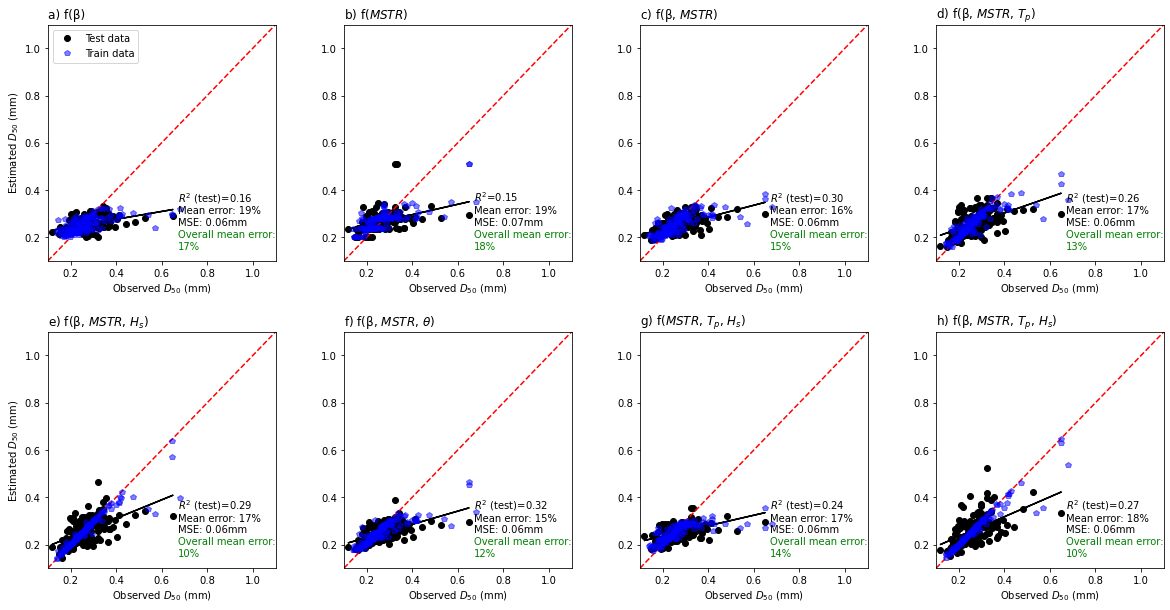

In [451]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.67,.35,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#
plt.savefig('../model_plots/EAus_d50-8models-skill.jpg', dpi=300, bbox_inches='tight')


In [452]:
X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
ds_est8 = model8.predict(X.T)

X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], rand))
ds_est4 = model4.predict(X.T)

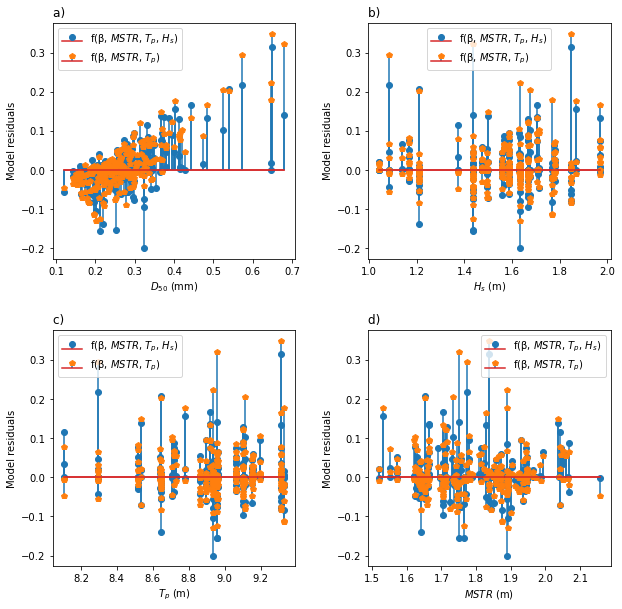

In [453]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(221)
plt.stem(dfEAus['d50'], dfEAus['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfEAus['d50'], dfEAus['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r"a) ", loc='left')

plt.subplot(222)
# plt.stem(dfEAus['hs_mean'], dfEAus['d50']-ds_est8, 'ko')
plt.stem(dfEAus['hs_mean'], dfEAus['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfEAus['hs_mean'], dfEAus['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$H_s$ (m)')
plt.title(r"b) ", loc='left')

plt.subplot(223)
# plt.stem(dfEAus['tp'], dfEAus['d50']-ds_est8, 'ko')
plt.stem(dfEAus['tp'], dfEAus['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfEAus['tp'], dfEAus['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$T_p$ (m)')
plt.title(r"c) ", loc='left')

plt.subplot(224)
# plt.stem(dfEAus['mstr'], dfEAus['d50']-ds_est8, 'ko')
plt.stem(dfEAus['mstr'], dfEAus['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfEAus['mstr'], dfEAus['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$MSTR$ (m)')
plt.title(r"d) ", loc='left')

plt.savefig('../model_plots/EAus_d50-model8_residuals-skill.jpg', dpi=300, bbox_inches='tight')


In [454]:
mm = dfEAus['d50'].mean()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

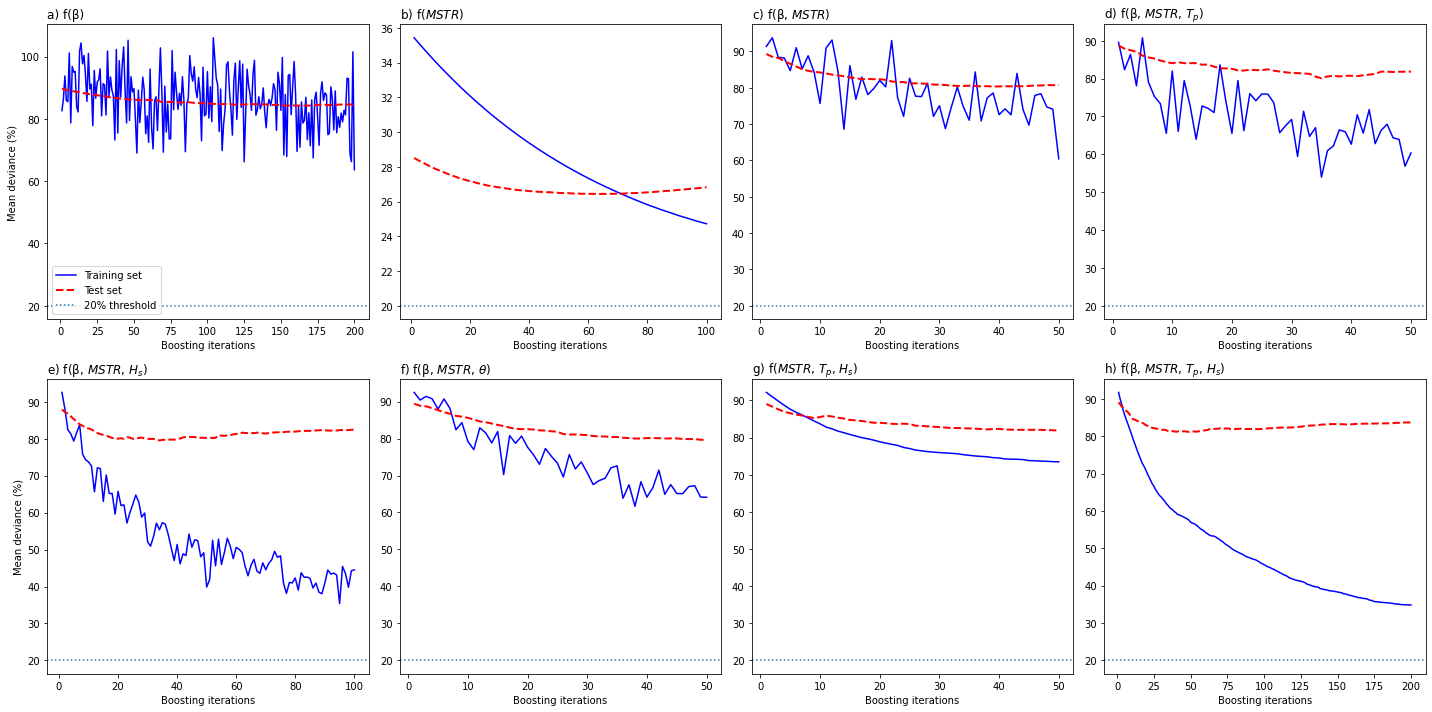

In [455]:
fig=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

####################
test_score = np.zeros((model1.n_estimators,), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)

plt.subplot(2, 4, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(model1.n_estimators) + 1,
    100*(np.sqrt(model1.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model1.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
# plt.ylim(10,50)
plt.legend(loc=0)

###########################
test_score = np.zeros((model2.n_estimators,), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(2,4, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(model2.n_estimators) + 1,
    100*(np.sqrt(model2.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model2.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)

#############################
test_score = np.zeros((model3.n_estimators,), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)

plt.subplot(2,4, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(model3.n_estimators) + 1,
    100*(np.sqrt(model3.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model3.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)


#####################
test_score = np.zeros((model4.n_estimators,), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(2, 4, 4)
plt.title(r"d) f(β, $MSTR$, $T_p$) ", loc='left')
plt.plot(
    np.arange(model4.n_estimators) + 1,
    100*(np.sqrt(model4.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model4.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)

#####################
test_score = np.zeros((model5.n_estimators,), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)
    
plt.subplot(2,4, 5)
plt.title(r"e) f(β, $MSTR$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model5.n_estimators) + 1,
    100*(np.sqrt(model5.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model5.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
# plt.ylim(10,50)

#####################
test_score = np.zeros((model6.n_estimators,), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(2, 4, 6)
plt.title(r"f) f(β, $MSTR$, $\theta$) ", loc='left')
plt.plot(
    np.arange(model6.n_estimators) + 1,
    100*(np.sqrt(model6.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model6.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)

#####################
test_score = np.zeros((model7.n_estimators,), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(2, 4, 7)
plt.title(r"g) f($MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model7.n_estimators) + 1,
    100*(np.sqrt(model7.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model7.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)

#####################
test_score = np.zeros((model8.n_estimators,), dtype=np.float64)
for i, y_pred8 in enumerate(model8.staged_predict(X_test8)):
    test_score[i] = model8.loss_(y_test8, y_pred8)
    
plt.subplot(2, 4, 8)
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model8.n_estimators) + 1,
    100*(np.sqrt(model8.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model8.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
# plt.ylim(10,50)

fig.tight_layout()

plt.savefig('../model_plots/EAus_d50-8models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

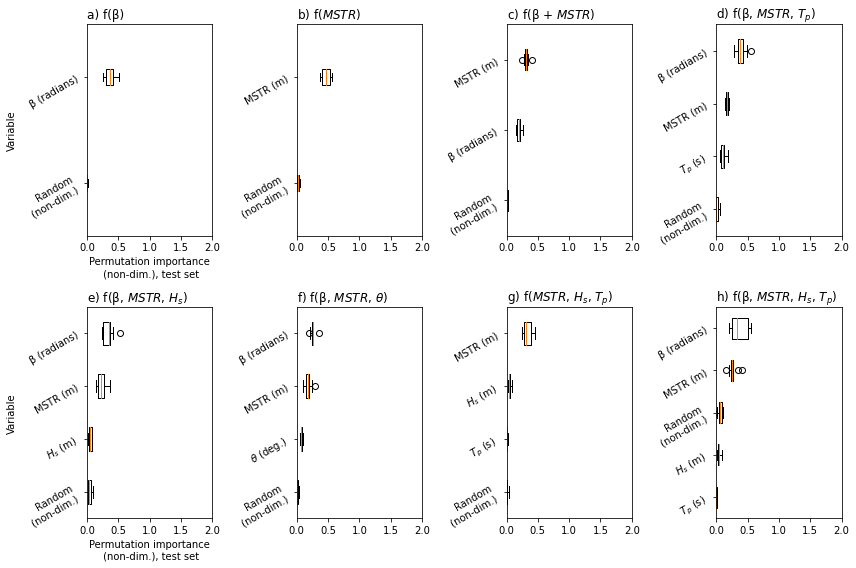

In [456]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(241)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#########################
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(242)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(243)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(244)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(245)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(246)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(247)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"g) f($MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model8, X_test8, y_test8, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(248)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names8)[sorted_idx],
)
plt.setp(ax.get_yticklabels (), rotation=30)
plt.xlim(0,2)
plt.title(r"h) f(β, $MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

fig.tight_layout()
plt.savefig('../model_plots/EAus_d50-8models-featimps.jpg', dpi=300, bbox_inches='tight')


In [457]:
np.save('../model_out/dataset_EAus_coast_model1.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model2.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model4.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model5.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model6.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model7.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_EAus_coast_model8.npy', model8out, allow_pickle=True)

US

In [458]:

parameters = {
    'n_estimators':[50, 100,200, 500], 
    'max_depth':[3,5,7,9], 
    "min_samples_split":[3,5,7,9], 
    "learning_rate": [0.01,0.05, 0.1], 
    "subsample": [0.25,0.5,0.75,1.0],
    "loss": ["squared_error", "absolute_error", "huber"]
}

In [459]:
# rand = np.random.randn(len(dfSEUS))
# np.save('../model_out/SEUS_rand.npy', rand, allow_pickle=True)

In [460]:
rand = np.load('../model_out/SEUS_rand.npy', allow_pickle=True)

In [461]:
Smean = []
Sstd = []

# params = {
#     "n_estimators": 500,
#     "max_depth": 4,
#     "min_samples_split": 5,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }


test_size = 0.5

standardize = False

In [462]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')
    
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0159


In [463]:
model1.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 500,
 'subsample': 1.0}

In [464]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

In [465]:
model1 = model1.best_estimator_

In [466]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.107 (0.039)


In [467]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((dfSEUS['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')
    
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test2.max())
print(y_train2.max())

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0064


In [468]:
model2.best_params_

{'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 9,
 'min_samples_split': 3,
 'n_estimators': 200,
 'subsample': 1.0}

In [469]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

In [470]:
model2 = model2.best_estimator_

In [471]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.069 (0.036)


In [472]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')


X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test3.max())
print(y_train3.max())

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0083


In [473]:
model3.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 5,
 'min_samples_split': 7,
 'n_estimators': 200,
 'subsample': 1.0}

In [474]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

In [475]:
model3 = model3.best_estimator_

In [476]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.062 (0.040)


In [477]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test4.max())
print(y_train4.max())

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0055


In [478]:
model4.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 200,
 'subsample': 1.0}

In [479]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

In [480]:
model4 = model4.best_estimator_

In [481]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.054 (0.030)


In [482]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['hs_mean'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test5.max())
print(y_train5.max())

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0159


In [483]:
model5.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 5,
 'min_samples_split': 5,
 'n_estimators': 500,
 'subsample': 1.0}

In [484]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

In [485]:
model5 = model5.best_estimator_

In [486]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.085 (0.045)


In [487]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['dir'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test6.max())
print(y_train6.max())

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0055


In [488]:
model6.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 5,
 'min_samples_split': 3,
 'n_estimators': 200,
 'subsample': 0.75}

In [489]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

In [490]:
model6 = model6.best_estimator_

In [491]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.063 (0.035)


In [492]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfSEUS['mstr'], dfSEUS['tp'], dfSEUS['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test7.max())
print(y_train7.max())

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0078


In [493]:
model7.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 7,
 'min_samples_split': 7,
 'n_estimators': 200,
 'subsample': 0.75}

In [494]:
model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

In [495]:
model7 = model7.best_estimator_

In [496]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.072 (0.035)


In [497]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['tp'], dfSEUS['hs_mean'],  rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfSEUS['d50'], test_size=test_size, random_state=2022
)

print(y_test8.max())
print(y_train8.max())

# model8 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0054


In [498]:
model8.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_split': 5,
 'n_estimators': 500,
 'subsample': 1.0}

In [499]:
model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

In [500]:
model8 = model8.best_estimator_

In [501]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.051 (0.028)


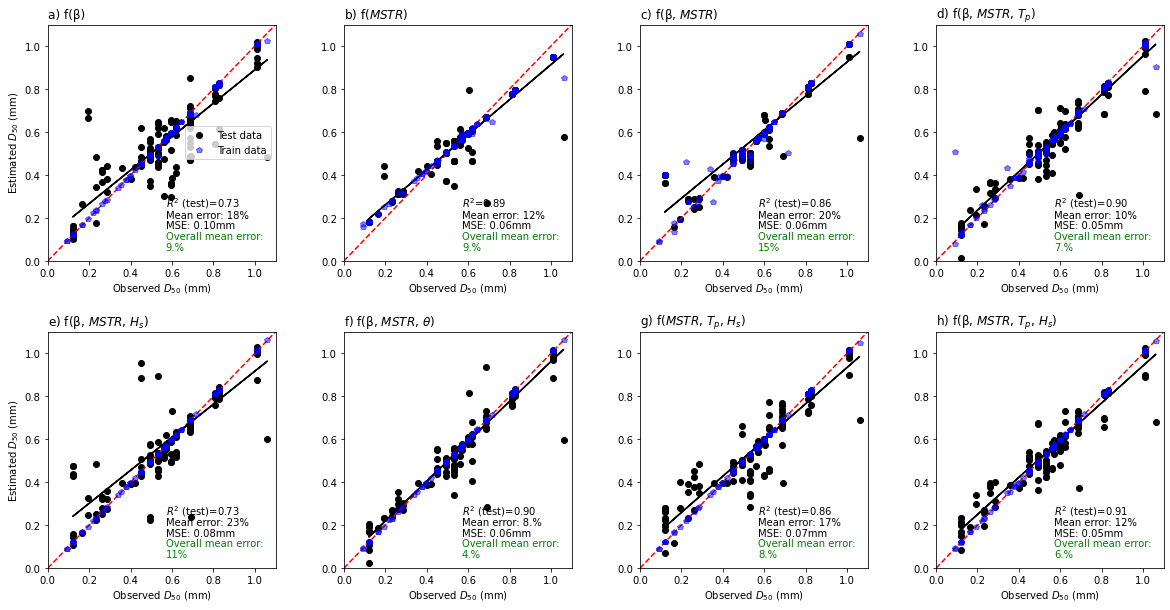

In [502]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=5)

plt.text(.57,.10, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.57,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#
plt.savefig('../model_plots/SEUS_d50-8models-skill.jpg', dpi=300, bbox_inches='tight')


In [503]:
len(dfSEUS)

270

In [504]:
X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['tp'], dfSEUS['hs_mean'],  rand))
ds_est8 = model8.predict(X.T)

X = np.stack((dfSEUS['beach_slope_average'], dfSEUS['mstr'], dfSEUS['tp'], rand))
ds_est4 = model4.predict(X.T)

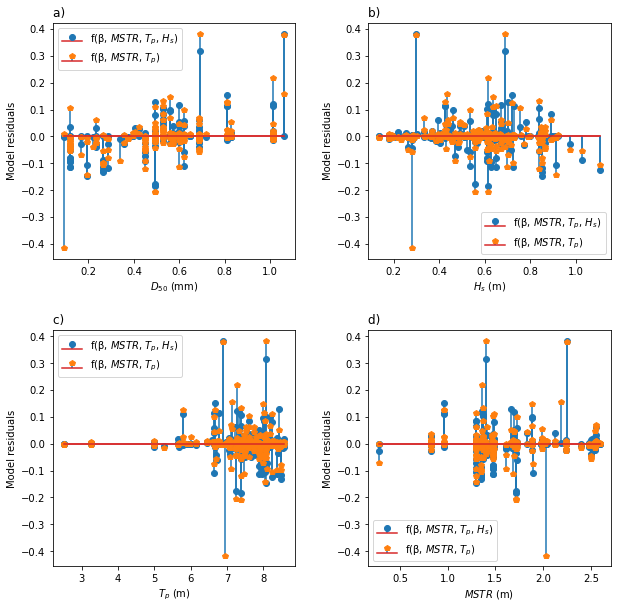

In [505]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(221)
plt.stem(dfSEUS['d50'], dfSEUS['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfSEUS['d50'], dfSEUS['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r"a) ", loc='left')

plt.subplot(222)
# plt.stem(dfSEUS['hs_mean'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(dfSEUS['hs_mean'], dfSEUS['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfSEUS['hs_mean'], dfSEUS['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$H_s$ (m)')
plt.title(r"b) ", loc='left')

plt.subplot(223)
# plt.stem(dfSEUS['tp'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(dfSEUS['tp'], dfSEUS['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfSEUS['tp'], dfSEUS['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$T_p$ (m)')
plt.title(r"c) ", loc='left')

plt.subplot(224)
# plt.stem(dfSEUS['mstr'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(dfSEUS['mstr'], dfSEUS['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(dfSEUS['mstr'], dfSEUS['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$MSTR$ (m)')
plt.title(r"d) ", loc='left')

plt.savefig('../model_plots/SEUS_d50-model8_residuals-skill.jpg', dpi=300, bbox_inches='tight')


In [506]:
mm = dfSEUS['d50'].mean()

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

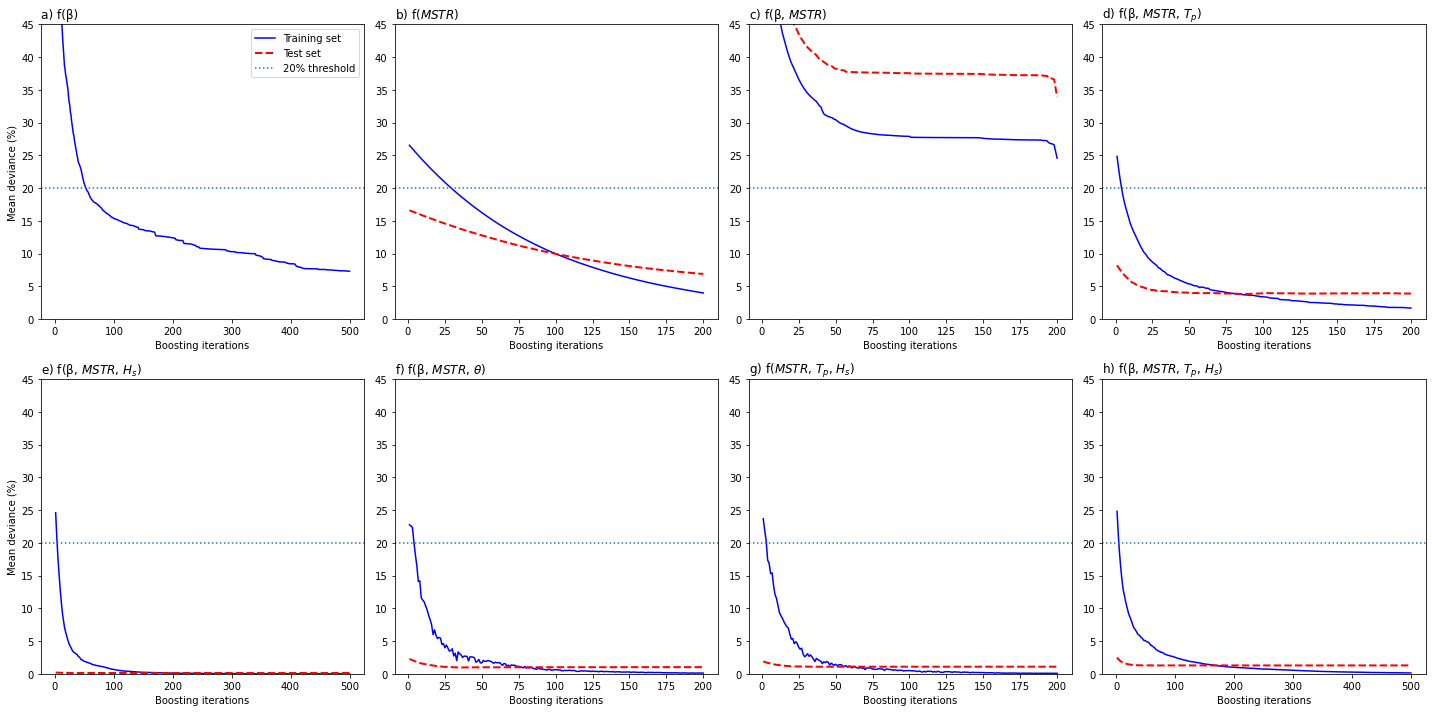

In [507]:
fig=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

####################
test_score = np.zeros((model1.n_estimators,), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)

plt.subplot(2, 4, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(model1.n_estimators) + 1,
    100*(np.sqrt(model1.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model1.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,45)
plt.legend(loc=0)

###########################
test_score = np.zeros((model2.n_estimators,), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(2,4, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(model2.n_estimators) + 1,
    100*(np.sqrt(model2.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model2.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#############################
test_score = np.zeros((model3.n_estimators,), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)

plt.subplot(2,4, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(model3.n_estimators) + 1,
    100*(np.sqrt(model3.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model3.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model4.n_estimators,), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(2, 4, 4)
plt.title(r"d) f(β, $MSTR$, $T_p$) ", loc='left')
plt.plot(
    np.arange(model4.n_estimators) + 1,
    100*(np.sqrt(model4.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model4.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model5.n_estimators,), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)
    
plt.subplot(2,4, 5)
plt.title(r"e) f(β, $MSTR$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model5.n_estimators) + 1,
    100*(np.sqrt(model5.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model5.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model6.n_estimators,), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(2, 4, 6)
plt.title(r"f) f(β, $MSTR$, $\theta$) ", loc='left')
plt.plot(
    np.arange(model6.n_estimators) + 1,
    100*(np.sqrt(model6.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model6.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model7.n_estimators,), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(2, 4, 7)
plt.title(r"g) f($MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model7.n_estimators) + 1,
    100*(np.sqrt(model7.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model7.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model8.n_estimators,), dtype=np.float64)
for i, y_pred8 in enumerate(model8.staged_predict(X_test8)):
    test_score[i] = model8.loss_(y_test8, y_pred8)
    
plt.subplot(2, 4, 8)
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model8.n_estimators) + 1,
    100*(np.sqrt(model8.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model8.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

fig.tight_layout()

plt.savefig('../model_plots/SEUS_d50-8models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

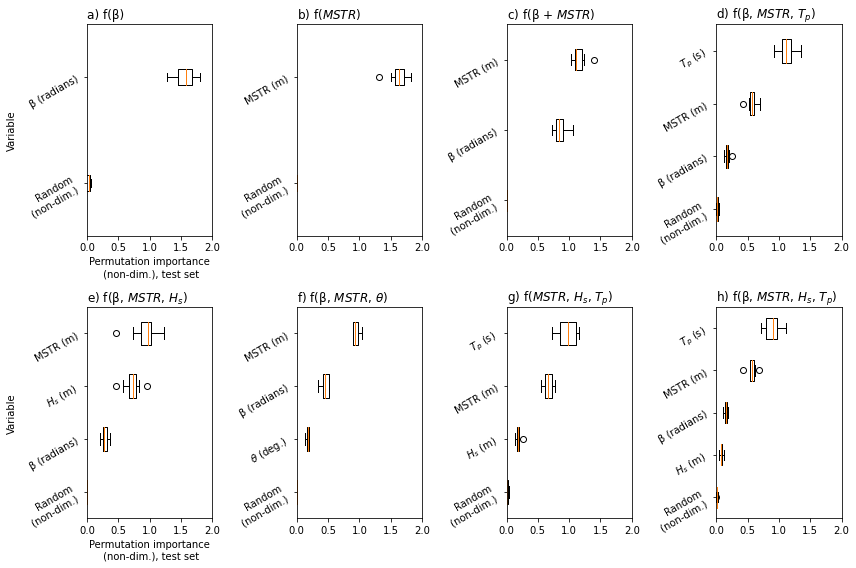

In [508]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(241)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#########################
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(242)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(243)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(244)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(245)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(246)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(247)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"g) f($MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model8, X_test8, y_test8, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(248)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names8)[sorted_idx],
)
plt.setp(ax.get_yticklabels (), rotation=30)
plt.xlim(0,2)
plt.title(r"h) f(β, $MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

fig.tight_layout()
plt.savefig('../model_plots/SEUS_d50-8models-featimps.jpg', dpi=300, bbox_inches='tight')


In [509]:
np.save('../model_out/dataset_SEUS_coast_model1.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model2.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model4.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model5.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model6.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model7.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_coast_model8.npy', model8out, allow_pickle=True)


In [510]:
## combined US-AUs

In [519]:
# params = {
#     "n_estimators": 500,
#     "max_depth": 6,
#     "min_samples_split": 5,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }

# test_size = 0.75

test_size = 0.5

standardize = False

In [524]:
# rand = np.random.randn(len(df))
# np.save('../model_out/SEUS_EOz_rand.npy', rand, allow_pickle=True)

In [525]:
rand = np.load('../model_out/SEUS_EOz_rand.npy', allow_pickle=True)

In [526]:
Smean = []
Sstd = []

In [527]:
# len(df[df['code']==1])

In [528]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], rand))
X.shape

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0230


In [529]:
model1.best_params_

{'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'min_samples_split': 5,
 'n_estimators': 200,
 'subsample': 1.0}

In [530]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

In [531]:
model1 = model1.best_estimator_

In [532]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.139 (0.027)


In [533]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
# X = np.stack((df['beach_slope_median'],df['mstr'], rand))
X = np.stack((df['mstr'], rand))
# X = np.stack((df['beach_slope'],df['mstr'], rand))
X.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test2.max())
print(y_train2.max())

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0159


In [534]:
model2.best_params_

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 5,
 'min_samples_split': 9,
 'n_estimators': 200,
 'subsample': 1.0}

In [535]:
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

In [536]:
model2 = model2.best_estimator_

In [537]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.112 (0.032)


In [538]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], df['mstr'], rand))
X.shape

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test3.max())
print(y_train3.max())

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0134


In [539]:
model3.best_params_

{'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200,
 'subsample': 0.75}

In [540]:
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

In [541]:
model3 = model3.best_estimator_

In [542]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.109 (0.032)


In [543]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], rand))
X.shape

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test4.max())
print(y_train4.max())

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0074


In [544]:
model4.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 200,
 'subsample': 0.75}

In [545]:
model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

In [546]:
model4 = model4.best_estimator_

In [547]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.087 (0.021)


In [548]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], df['mstr'], df['hs_mean'], rand))
X.shape

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test5.max())
print(y_train5.max())

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076


In [549]:
model5.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 500,
 'subsample': 1.0}

In [550]:
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

In [551]:
model5 = model5.best_estimator_

In [552]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.088 (0.023)


In [553]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], df['mstr'], df['dir'], rand))
X.shape

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test6.max())
print(y_train6.max())

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0089


In [554]:
model6.best_params_

{'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 9,
 'min_samples_split': 9,
 'n_estimators': 200,
 'subsample': 0.5}

In [555]:
model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

In [556]:
model6 = model6.best_estimator_

In [557]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.088 (0.019)


In [558]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((df['mstr'], df['tp'], df['hs_mean'],  rand))
X.shape

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test7.max())
print(y_train7.max())

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0086


In [559]:
model7.best_params_

{'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'min_samples_split': 9,
 'n_estimators': 500,
 'subsample': 1.0}

In [560]:
model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

In [561]:
model7 = model7.best_estimator_

In [562]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.090 (0.020)


In [563]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
X.shape

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, df['d50'], test_size=test_size, random_state=2022
)

print(y_test8.max())
print(y_train8.max())

# model8 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0056


In [564]:
model8.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 500,
 'subsample': 1.0}

In [565]:
model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

In [566]:
model8 = model8.best_estimator_

In [567]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.084 (0.022)


In [568]:
# y_train1.max()
# y_train1.min()

In [569]:
### model skill

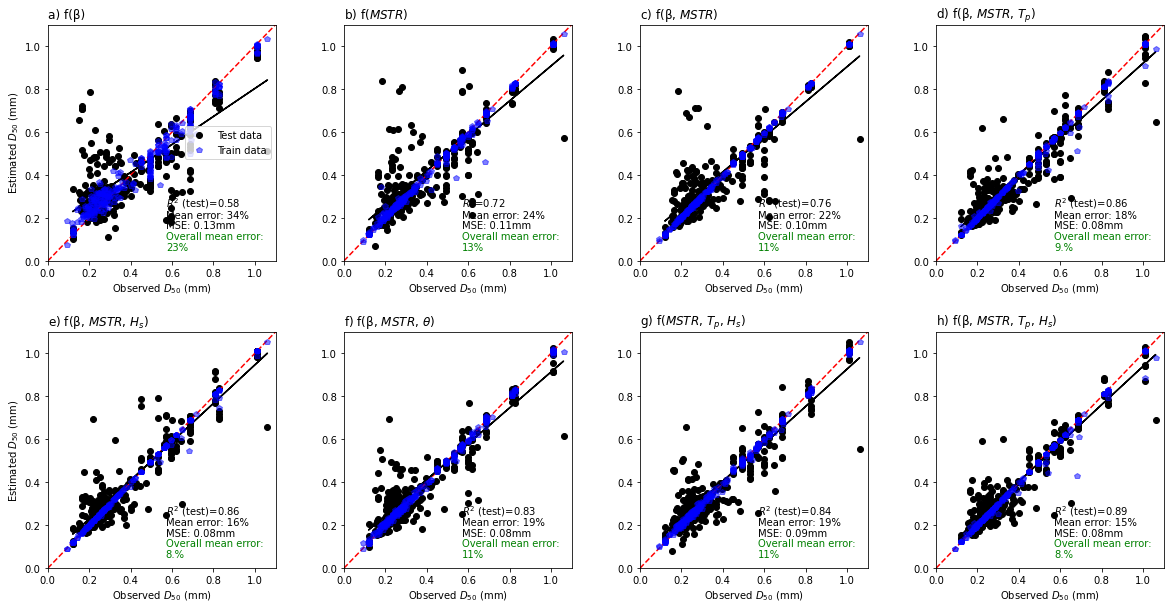

In [570]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=5)

plt.text(.57,.10, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.57,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.1, r'Overall mean error:', color='g')
plt.text(.57,.05, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/SEUS-EOz_d50-8models-skill.jpg', dpi=300, bbox_inches='tight')


In [571]:
X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
ds_est8 = model8.predict(X.T)

X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], rand))
ds_est4 = model4.predict(X.T)

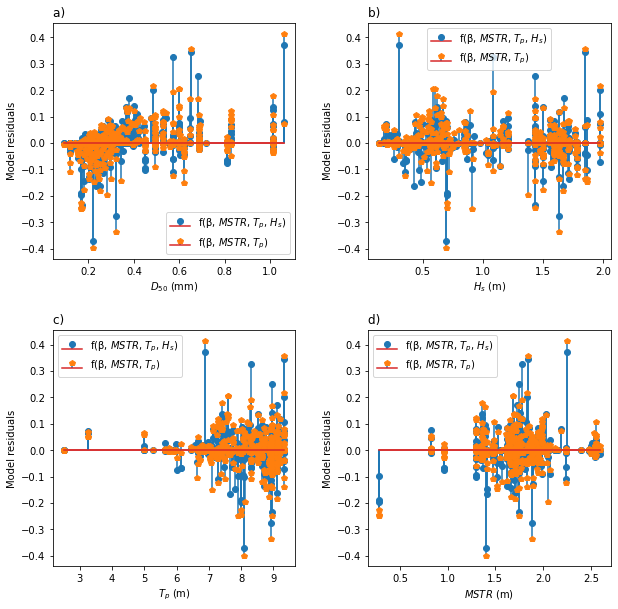

In [572]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(221)
plt.stem(df['d50'], df['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(df['d50'], df['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r"a) ", loc='left')

plt.subplot(222)
# plt.stem(dfSEUS['hs_mean'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(df['hs_mean'], df['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(df['hs_mean'], df['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$H_s$ (m)')
plt.title(r"b) ", loc='left')

plt.subplot(223)
# plt.stem(dfSEUS['tp'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(df['tp'], df['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(df['tp'], df['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$T_p$ (m)')
plt.title(r"c) ", loc='left')

plt.subplot(224)
# plt.stem(dfSEUS['mstr'], dfSEUS['d50']-ds_est8, 'ko')
plt.stem(df['mstr'], df['d50']-ds_est8,  markerfmt='o', linefmt='-', label=r"f(β, $MSTR$, $T_p$, $H_s$)")
plt.stem(df['mstr'], df['d50']-ds_est4,  markerfmt='p', linefmt='-', label = r"f(β, $MSTR$, $T_p$)" )
plt.legend()
plt.ylabel(r'Model residuals')
plt.xlabel(r'$MSTR$ (m)')
plt.title(r"d) ", loc='left')

plt.savefig('../model_plots/SEUS-EOz_d50-model8_residuals-skill.jpg', dpi=300, bbox_inches='tight')


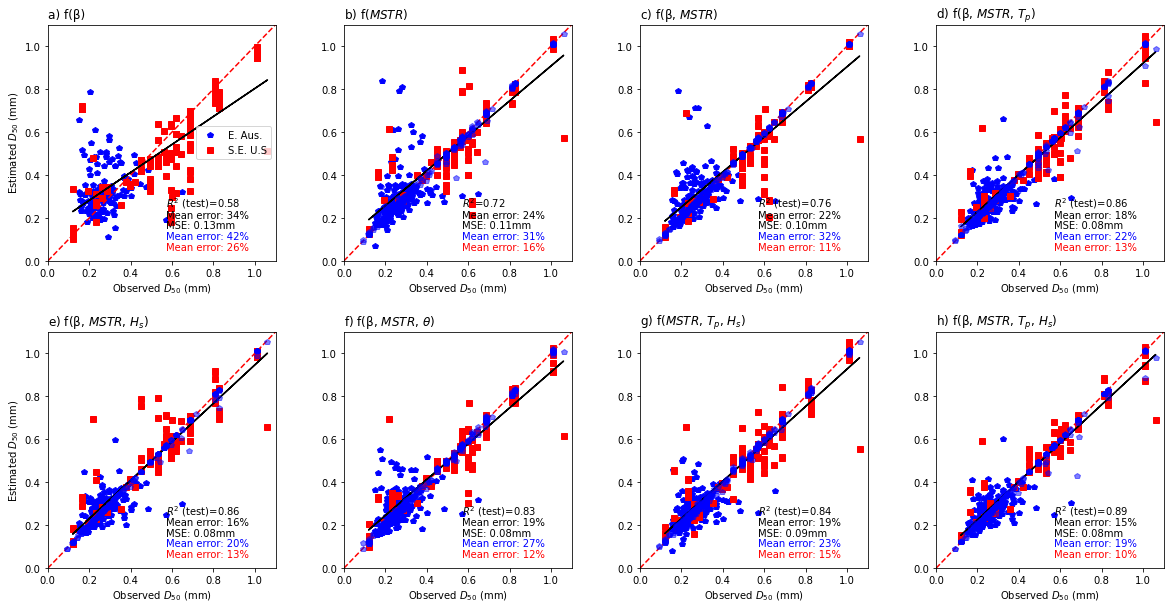

In [573]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

C = np.stack((df['code']))
C_train1, C_test1, _, _ = train_test_split(
    C.T, df['d50'], test_size=test_size, random_state=2022
)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test1[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[0])[:4]))

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')
plt.legend(loc=5)

plt.subplot(242)
ds_est = model2.predict(X_test2)
# plt.plot(y_test2, ds_est, 'ko')
plt.plot(y_test2[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test2[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.57,.25,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')


plt.subplot(243)
ds_est = model3.predict(X_test3)
# plt.plot(y_test3, ds_est, 'ko')
plt.plot(y_test3[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test3[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.57,.20, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test4[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
# plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')


plt.subplot(245)
ds_est = model5.predict(X_test5)
# plt.plot(y_test5, ds_est, 'ko')
plt.plot(y_test5[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test5[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')


plt.subplot(246)
ds_est = model6.predict(X_test6)
# plt.plot(y_test6, ds_est, 'ko')
plt.plot(y_test6[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test6[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')

plt.subplot(247)
ds_est = model7.predict(X_test7)
# plt.plot(y_test7, ds_est, 'ko')
plt.plot(y_test7[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test7[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')

plt.subplot(248)
ds_est = model8.predict(X_test8)
# plt.plot(y_test8, ds_est, 'ko')
plt.plot(y_test8[C_test1==0], ds_est[C_test1==0], 'bp', label='E. Aus.')
plt.plot(y_test8[C_test1==1], ds_est[C_test1==1], 'rs', label='S.E. U.S')
plt.xlim(0,1.1); plt.ylim(0,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.57,.25,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.57,.2, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.57,.15, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.57,.10, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8[C_test1==0],ds_est[C_test1==0])))[:2]), color='b')
plt.text(.57,.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8[C_test1==1],ds_est[C_test1==1])))[:2]), color='r')

plt.savefig('../model_plots/SEUS-EOz_d50-8models-skill-2regions.jpg', dpi=300, bbox_inches='tight')


C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\sklearn\utils\deprecation

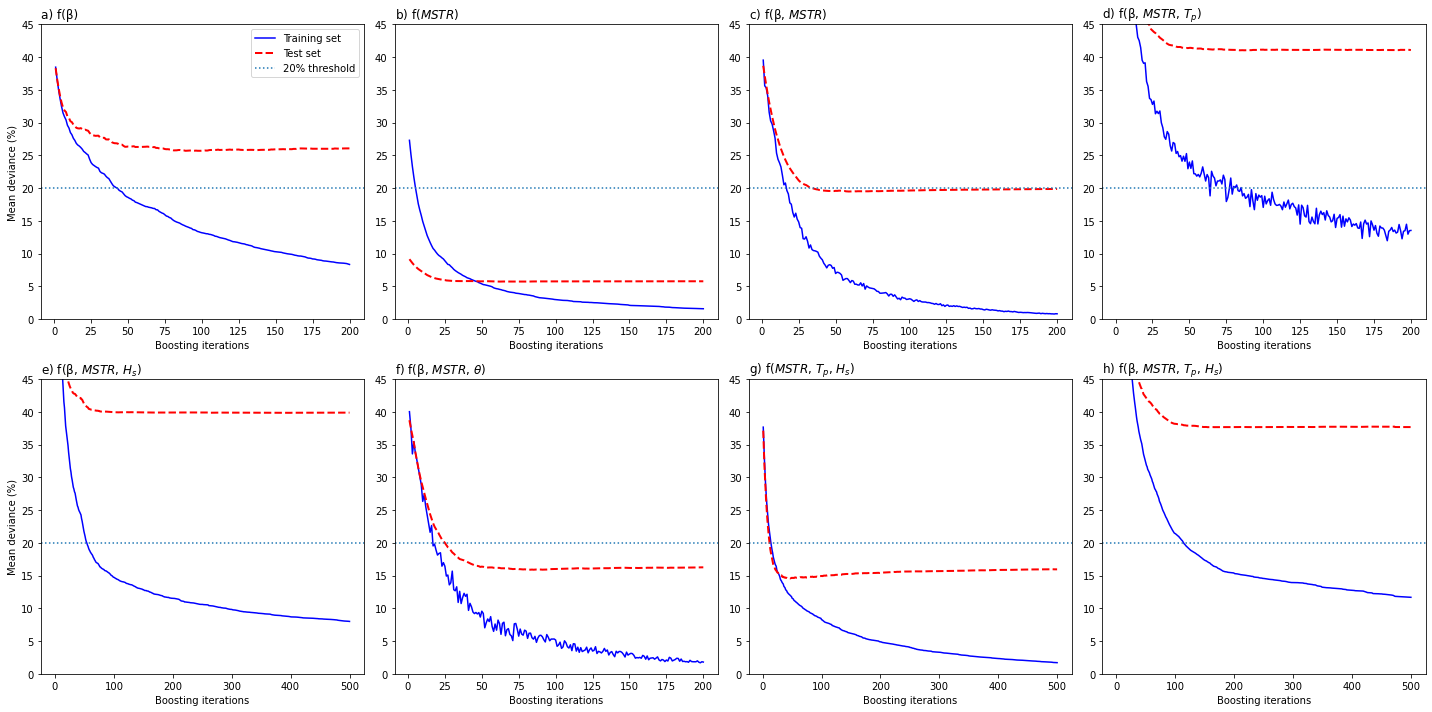

In [575]:
fig=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

####################
test_score = np.zeros((model1.n_estimators,), dtype=np.float64)
for i, y_pred1 in enumerate(model1.staged_predict(X_test1)):
    test_score[i] = model1.loss_(y_test1, y_pred1)

plt.subplot(2, 4, 1)
plt.title(r"a) f(β)", loc='left')
plt.plot(
    np.arange(model1.n_estimators) + 1,
    100*(np.sqrt(model1.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model1.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,45)
plt.legend(loc=0)

###########################
test_score = np.zeros((model2.n_estimators,), dtype=np.float64)
for i, y_pred2 in enumerate(model2.staged_predict(X_test2)):
    test_score[i] = model2.loss_(y_test2, y_pred2)

plt.subplot(2,4, 2)
plt.title(r"b) f($MSTR$)", loc='left')
plt.plot(
    np.arange(model2.n_estimators) + 1,
    100*(np.sqrt(model2.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model2.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#############################
test_score = np.zeros((model3.n_estimators,), dtype=np.float64)
for i, y_pred3 in enumerate(model3.staged_predict(X_test3)):
    test_score[i] = model3.loss_(y_test3, y_pred3)

plt.subplot(2,4, 3)
plt.title("c) f(β, $MSTR$)", loc='left')
plt.plot(
    np.arange(model3.n_estimators) + 1,
    100*(np.sqrt(model3.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model3.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model4.n_estimators,), dtype=np.float64)
for i, y_pred4 in enumerate(model4.staged_predict(X_test4)):
    test_score[i] = model4.loss_(y_test4, y_pred4)
    
plt.subplot(2, 4, 4)
plt.title(r"d) f(β, $MSTR$, $T_p$) ", loc='left')
plt.plot(
    np.arange(model4.n_estimators) + 1,
    100*(np.sqrt(model4.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model4.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model5.n_estimators,), dtype=np.float64)
for i, y_pred5 in enumerate(model5.staged_predict(X_test5)):
    test_score[i] = model5.loss_(y_test5, y_pred5)
    
plt.subplot(2,4, 5)
plt.title(r"e) f(β, $MSTR$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model5.n_estimators) + 1,
    100*(np.sqrt(model5.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model5.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
plt.ylabel("Mean deviance (%)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model6.n_estimators,), dtype=np.float64)
for i, y_pred6 in enumerate(model6.staged_predict(X_test6)):
    test_score[i] = model6.loss_(y_test6, y_pred6)
    
plt.subplot(2, 4, 6)
plt.title(r"f) f(β, $MSTR$, $\theta$) ", loc='left')
plt.plot(
    np.arange(model6.n_estimators) + 1,
    100*(np.sqrt(model6.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model6.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model7.n_estimators,), dtype=np.float64)
for i, y_pred7 in enumerate(model7.staged_predict(X_test7)):
    test_score[i] = model7.loss_(y_test7, y_pred7)
    
plt.subplot(2, 4, 7)
plt.title(r"g) f($MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model7.n_estimators) + 1,
    100*(np.sqrt(model7.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model7.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

#####################
test_score = np.zeros((model8.n_estimators,), dtype=np.float64)
for i, y_pred8 in enumerate(model8.staged_predict(X_test8)):
    test_score[i] = model8.loss_(y_test8, y_pred8)
    
plt.subplot(2, 4, 8)
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$) ", loc='left')
plt.plot(
    np.arange(model8.n_estimators) + 1,
    100*(np.sqrt(model8.train_score_)/mm),
    "b-",
    label="Training set",
)
plt.plot(
    np.arange(model8.n_estimators) + 1, 100*(np.sqrt(test_score)/mm), "r--", label="Test set", lw=2
)
plt.axhline(20, linestyle=':',label='20% threshold')
# plt.legend(loc="upper right")
plt.xlabel("Boosting iterations")
# plt.ylabel("Deviance (non-dim.)")
plt.ylim(0,45)

fig.tight_layout()

plt.savefig('../model_plots/SEUS-EOz_d50-8models-training-strat-lat.jpg', dpi=300, bbox_inches='tight')

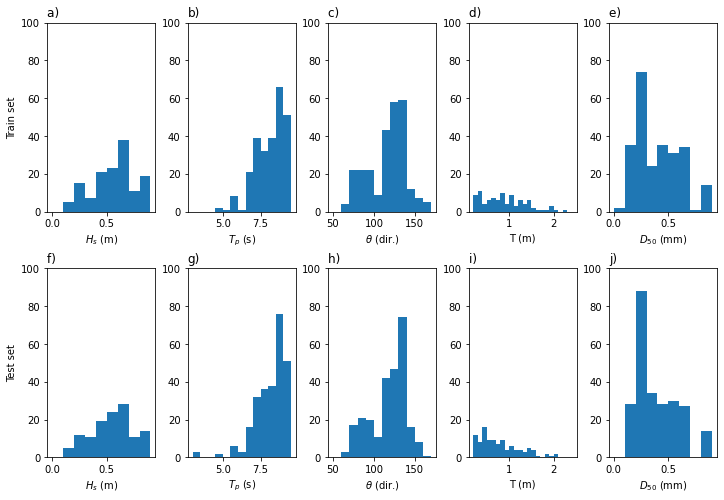

In [577]:
testlim = 100
trainlim = 100

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)


plt.subplot(2,5,1)
plt.hist(X_train5[:,2], bins=np.arange(0,1,.1))
plt.ylim(0,trainlim); plt.ylabel('Train set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'a) ', loc='left')

plt.subplot(2,5,2)
plt.hist(X_train4[:,2], bins=np.arange(3,10,.5))
plt.ylim(0,trainlim); plt.xlabel(r'$T_p$ (s)')
plt.title(r'b)', loc='left')

plt.subplot(2,5,3)
plt.hist(X_train6[:,2], bins=np.arange(50,180,10))
plt.ylim(0,trainlim); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'c) ', loc='left')

plt.subplot(2,5,4)
plt.hist(X_train4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,trainlim); plt.xlabel('T (m)')
plt.title(r'd) ', loc='left')

plt.subplot(2,5,5)
plt.hist(y_train4, bins=np.arange(0,1,.1))
plt.ylim(0,trainlim); plt.xlabel(r'$D_{50}$ (mm)')
plt.title(r'e) ', loc='left')

plt.subplot(2,5,6)
plt.hist(X_test5[:,2], bins=np.arange(0,1,.1))
plt.ylim(0,testlim); plt.ylabel('Test set'); plt.xlabel(r'$H_s$ (m)')
plt.title(r'f) ', loc='left')

plt.subplot(2,5,7)
plt.hist(X_test4[:,2], bins=np.arange(3,10,.5))
plt.ylim(0,testlim); plt.xlabel(r'$T_p$ (s)')
plt.title(r'g)', loc='left')

plt.subplot(2,5,8)
plt.hist(X_test6[:,2], bins=np.arange(50,180,10))
plt.ylim(0,testlim); plt.xlabel(r'$\theta$ (dir.)')
plt.title(r'h) ', loc='left')

plt.subplot(2,5,9)
plt.hist(X_test4[:,3], bins=np.arange(0.2,2.5,.1))
plt.ylim(0,testlim); plt.xlabel('T (m)')
plt.title(r'i) ', loc='left')

plt.subplot(2,5,10)
plt.hist(y_test4, bins=np.arange(0,1,.1))
plt.ylim(0,testlim); plt.xlabel('$D_{50}$ (mm)')
plt.title(r'j) ', loc='left')

plt.savefig('../data_plots/SEUS-EOz_d50-test_train_dists.jpg', dpi=300, bbox_inches='tight')

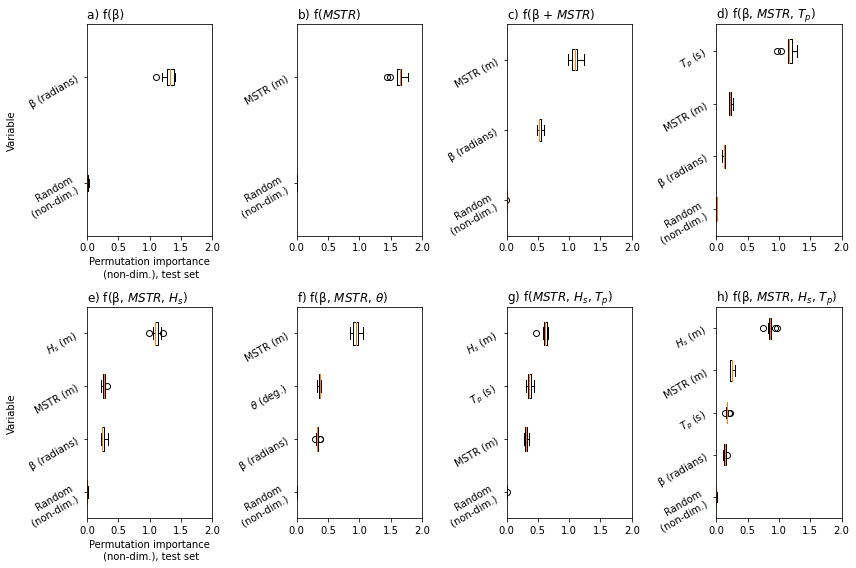

In [578]:

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

########################
result = permutation_importance(
    model1, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(241)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names1)[sorted_idx],
)

plt.xlim(0,2)
plt.title("a) f(β) ", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#########################
result = permutation_importance(
    model2, X_test2, y_test2, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(242)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names2)[sorted_idx],
)

plt.xlim(0,2)
plt.title("b) f($MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

#############################
result = permutation_importance(
    model3, X_test3, y_test3, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(243)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names3)[sorted_idx],
)

plt.xlim(0,2)
plt.title("c) f(β + $MSTR$) ", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model4, X_test4, y_test4, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(244)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names4)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

############################
result = permutation_importance(
    model5, X_test5, y_test5, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(245)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names5)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
plt.xlabel("Permutation importance\n (non-dim.), test set")
plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model6, X_test6, y_test6, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(246)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names6)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model7, X_test7, y_test7, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(247)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names7)[sorted_idx],
)
plt.xlim(0,2)
plt.title(r"g) f($MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")
plt.setp(ax.get_yticklabels (), rotation=30)

##################################
result = permutation_importance(
    model8, X_test8, y_test8, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
ax=plt.subplot(248)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names8)[sorted_idx],
)
plt.setp(ax.get_yticklabels (), rotation=30)
plt.xlim(0,2)
plt.title(r"h) f(β, $MSTR$, $H_s$, $T_p$)", loc='left')
# plt.xlabel("Permutation importance (non-dim.), test set")
# plt.ylabel("Variable")

fig.tight_layout()
plt.savefig('../model_plots/SEUS-EOz_d50-8models-featimps.jpg', dpi=300, bbox_inches='tight')


In [579]:
np.save('../model_out/dataset_SEUS_E_Aus_coast_model1.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model2.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model4.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model5.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model6.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model7.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_SEUS_E_Aus_coast_model8.npy', model8out, allow_pickle=True)


### whole Australia and Australia regions

make dataset

In [672]:
dataset = '../../../orig_data/australia/dataset_Australia_all.geojson'

dfOz = gpd.read_file(dataset)

dfOz = dfOz[dfOz['d50']<=1] #2
len(dfOz)

ind = np.where(dfOz['quality_flag']!='Low')[0]
len(ind)
dfOz = dfOz.iloc[ind]
len(dfOz)


ind = np.where(dfOz['distance_to_sample']<1000)[0]
len(ind)
dfOz = dfOz.iloc[ind]
len(dfOz)

dfOz = dfOz.dropna()
len(dfOz)

dfOz.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)

regions = '../../../orig_data/australia/sediment_compartments/Regions.geojson'
Oz_regions = gpd.read_file(regions)

dfOzregions = sjoin(dfOz, Oz_regions, how='left')



C:\Users\dbuscombe\AppData\Local\Temp\8\ipykernel_6484\2573412170.py:27: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4283

  dfOzregions = sjoin(dfOz, Oz_regions, how='left')


In [673]:
len(dfOz)

809

In [674]:
dfOz.to_csv('../model_data/dataset_Australia_All_coast_nostrat.csv')

In [676]:
dfOzNE = dfOzregions[dfOzregions['ID_Region']==1]
print(len(dfOzNE))

dfOzSE = dfOzregions[dfOzregions['ID_Region']==2]
print(len(dfOzSE))

dfOzS = dfOzregions[dfOzregions['ID_Region']==3]
print(len(dfOzS))

dfOzW = dfOzregions[dfOzregions['ID_Region']==4]
print(len(dfOzW))

dfOzNW = dfOzregions[dfOzregions['ID_Region']==5]
print(len(dfOzNW))

dfOzCG = dfOzregions[dfOzregions['ID_Region']==6] #Carpentaria Gulf
print(len(dfOzCG))

163
289
179
60
69
49


In [677]:
# dfOzNE.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzNE = dfOzNE[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

# dfOzSE.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzSE = dfOzSE[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

# dfOzNW.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzNW = dfOzNW[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

# dfOzS.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzS = dfOzS[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

# dfOzW.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzW = dfOzW[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

# dfOzCG.rename(columns = {'Hs_max':'hs_max', 'Hs_mean':'hs_mean', 'Tp_mean': 'tp', 'Wdir_mean':'dir'}, inplace = True)
dfOzCG = dfOzCG[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

In [678]:
dfOzCG.to_csv('../model_data/dataset_Australia_GulfCarpentaria_coast_nostrat.csv')
dfOzW.to_csv('../model_data/dataset_Australia_W_coast_nostrat.csv')
dfOzNW.to_csv('../model_data/dataset_Australia_NW_coast_nostrat.csv')
dfOzNE.to_csv('../model_data/dataset_Australia_NE_coast_nostrat.csv')
dfOzSE.to_csv('../model_data/dataset_Australia_SE_coast_nostrat.csv')
dfOzS.to_csv('../model_data/dataset_Australia_S_coast_nostrat.csv')

In [679]:
len(dfOz)

809

In [680]:
len(dfOzW)

60

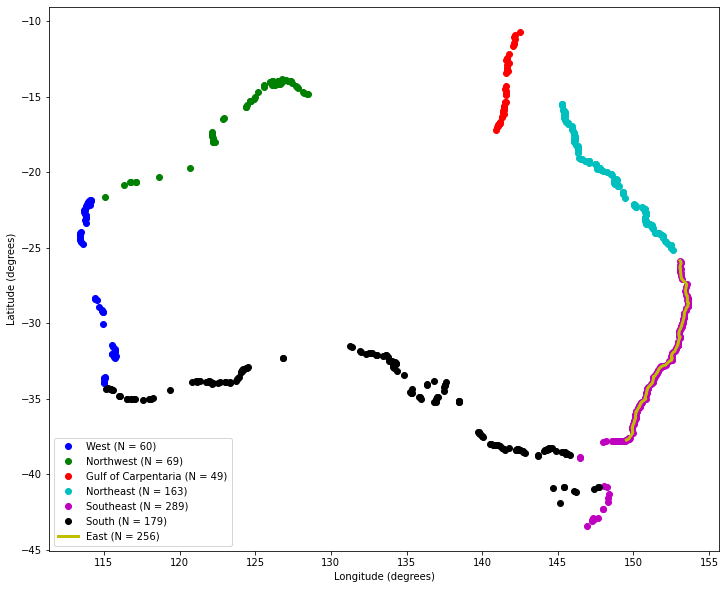

In [683]:
plt.figure(figsize=(12,10))
plt.plot(dfOzW['longitude'], dfOzW['latitude'],'bo', label='West (N = {})'.format(len(dfOzW)))
plt.plot(dfOzNW['longitude'], dfOzNW['latitude'],'go', label='Northwest (N = {})'.format(len(dfOzNW)))
plt.plot(dfOzCG['longitude'], dfOzCG['latitude'],'ro', label='Gulf of Carpentaria (N = {})'.format(len(dfOzCG)))
plt.plot(dfOzNE['longitude'], dfOzNE['latitude'],'co', label='Northeast (N = {})'.format(len(dfOzNE)))
plt.plot(dfOzSE['longitude'], dfOzSE['latitude'],'mo', label='Southeast (N = {})'.format(len(dfOzSE)))
plt.plot(dfOzS['longitude'], dfOzS['latitude'],'ko', label='South (N = {})'.format(len(dfOzS)))
plt.plot(dfEAus['longitude'], dfEAus['latitude'],'y-', lw=3, label='East (N = {})'.format(len(dfEAus)))

plt.legend(loc=3)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
# fig.tight_layout()
plt.savefig('../data_plots/OzRegions.jpg', dpi=300, bbox_inches='tight')


In [684]:
## model each region and whole of Oz

In [685]:
parameters = {
    'n_estimators':[50, 100,200, 500], 
    'max_depth':[3,5,7,9], 
    "min_samples_split":[3,5,7,9], 
    "learning_rate": [0.01,0.05, 0.1], 
    "subsample": [0.25,0.5,0.75,1.0],
    "loss": ["squared_error", "absolute_error", "huber"]
}

In [686]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [687]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']

for counter, df in enumerate([dfOz,dfOzW,dfOzNW,dfOzCG,dfOzNE,dfOzSE,dfOzS]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    # model8 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


model:0
0.97942
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0278
Mean RMSE: 0.168 (0.031)
model:1
0.92019
0.67362
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0365
Mean RMSE: 0.188 (0.068)
model:2
0.99309
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0567
Mean RMSE: 0.208 (0.098)
model:3
0.51406
0.51406
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0116
Mean RMSE: 0.082 (0.048)
model:4
0.95926
0.97265
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0329
Mean RMSE: 0.167 (0.065)
model:5
0.95264
0.70711
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0136
Mean RMSE: 0.105 (0.047)
model:6
0.92019


In [688]:
np.save('../model_out/dataset_whole_Aus_coast_model8.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_W_Aus_coast_model8.npy', MODELS[1], allow_pickle=True)
np.save('../model_out/dataset_NW_Aus_coast_model8.npy', MODELS[2], allow_pickle=True)
np.save('../model_out/dataset_CG_Aus_coast_model8.npy', MODELS[3], allow_pickle=True)
np.save('../model_out/dataset_NE_Aus_coast_model8.npy', MODELS[4], allow_pickle=True)
np.save('../model_out/dataset_SE_Aus_coast_model8.npy', MODELS[5], allow_pickle=True)
np.save('../model_out/dataset_S_Aus_coast_model8.npy', MODELS[6], allow_pickle=True)


In [689]:
# model8_Oz = np.load('../model_out/dataset_whole_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_WOz = np.load('../model_out/dataset_W_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_NWOz = np.load('../model_out/dataset_NW_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_CGOz = np.load('../model_out/dataset_CG_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_NEOz = np.load('../model_out/dataset_NE_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_SEOz = np.load('../model_out/dataset_SE_Aus_coast_model8.npy', allow_pickle=True).item(0)
# model8_SOz = np.load('../model_out/dataset_S_Aus_coast_model8.npy', allow_pickle=True).item(0)


In [690]:
regions = ['All','West','Northwest','G. Carpentaria','Northeast','Southeast','South']
ids = 'abcdefgh'

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


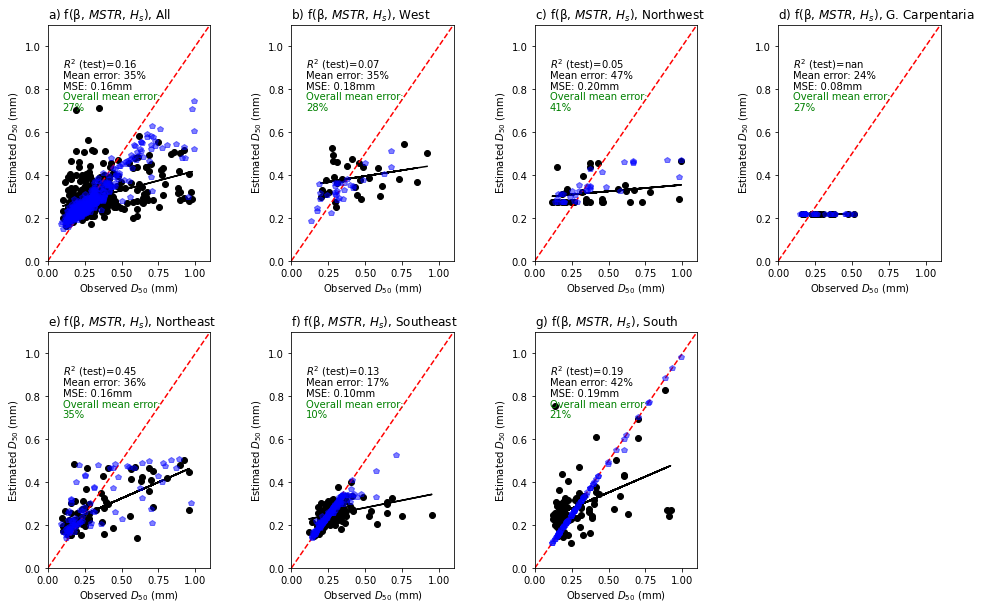

In [691]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [dfOz,dfOzW,dfOzNW,dfOzCG,dfOzNE,dfOzSE,dfOzS])):
    plt.subplot(2,4,counter+1)
    
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/Oz_d50-model8-skill-all-regions.jpg', dpi=300, bbox_inches='tight')
                        


In [692]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [693]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
for counter, df in enumerate([dfOz,dfOzW,dfOzNW,dfOzCG,dfOzNE,dfOzSE,dfOzS]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['hs_mean'], rand))
    X.shape

    X_train5, X_test5, y_train5, y_test5= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test5.max())
    print(y_train5.max())

    # model5 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model5.fit(X_train5, y_train5)

    mse8 = mean_squared_error(y_test5,model5.predict(X_test5))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))
    
    model5out = {}
    model5out['feature_names'] = feature_names5
    model5out['Xtest'] = X_test5
    model5out['Xtrain'] = X_train5
    model5out['ytest'] = y_test5
    model5out['ytrain'] = y_train5
    model5out['model'] = model5
    model5out['mse'] = mse5
    model5out['best_params'] = model5.best_params_
    
    model5 = model5.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model5out)
    BEST_MODELS.append(model5)


model:0
0.97942
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.163 (0.030)
model:1
0.92019
0.67362
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.177 (0.061)
model:2
0.99309
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.204 (0.098)
model:3
0.51406
0.51406
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.113 (0.043)
model:4
0.95926
0.97265
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.169 (0.064)
model:5
0.95264
0.70711
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.101 (0.052)
model:6
0.92019


In [694]:
np.save('../model_out/dataset_whole_Aus_coast_model5.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_W_Aus_coast_model5.npy', MODELS[1], allow_pickle=True)
np.save('../model_out/dataset_NW_Aus_coast_model5.npy', MODELS[2], allow_pickle=True)
np.save('../model_out/dataset_CG_Aus_coast_model5.npy', MODELS[3], allow_pickle=True)
np.save('../model_out/dataset_NE_Aus_coast_model5.npy', MODELS[4], allow_pickle=True)
np.save('../model_out/dataset_SE_Aus_coast_model5.npy', MODELS[5], allow_pickle=True)
np.save('../model_out/dataset_S_Aus_coast_model5.npy', MODELS[6], allow_pickle=True)


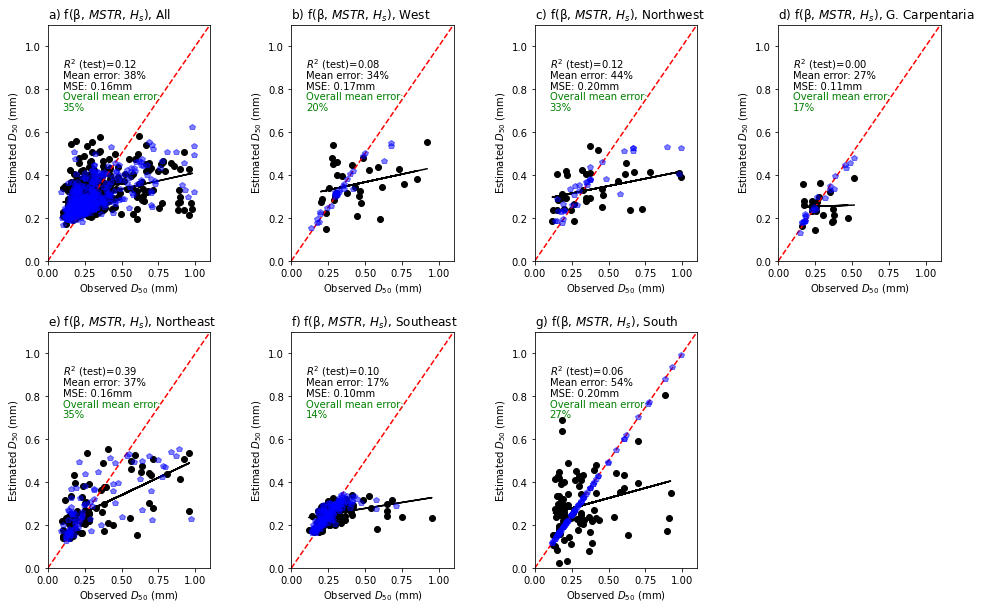

In [695]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [dfOz,dfOzW,dfOzNW,dfOzCG,dfOzNE,dfOzSE,dfOzS])):
    plt.subplot(2,4,counter+1)
    
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['hs_mean'],  rand))
    X.shape

    X_train5, X_test5, y_train5, y_test5= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test5)
    plt.plot(y_test5, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test5, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test5, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test5, poly1d_fn(y_test5), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train5)
    plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/Oz_d50-model5-skill-all-regions.jpg', dpi=300, bbox_inches='tight')
                        


In [696]:
[m['best_params'] for m in MODELS]

[{'learning_rate': 0.05,
  'loss': 'huber',
  'max_depth': 5,
  'min_samples_split': 9,
  'n_estimators': 50,
  'subsample': 0.25},
 {'learning_rate': 0.1,
  'loss': 'absolute_error',
  'max_depth': 3,
  'min_samples_split': 5,
  'n_estimators': 500,
  'subsample': 0.25},
 {'learning_rate': 0.05,
  'loss': 'absolute_error',
  'max_depth': 9,
  'min_samples_split': 7,
  'n_estimators': 50,
  'subsample': 0.5},
 {'learning_rate': 0.05,
  'loss': 'squared_error',
  'max_depth': 3,
  'min_samples_split': 5,
  'n_estimators': 500,
  'subsample': 0.25},
 {'learning_rate': 0.05,
  'loss': 'absolute_error',
  'max_depth': 9,
  'min_samples_split': 7,
  'n_estimators': 50,
  'subsample': 0.25},
 {'learning_rate': 0.01,
  'loss': 'absolute_error',
  'max_depth': 3,
  'min_samples_split': 3,
  'n_estimators': 500,
  'subsample': 0.75},
 {'learning_rate': 0.1,
  'loss': 'squared_error',
  'max_depth': 3,
  'min_samples_split': 5,
  'n_estimators': 500,
  'subsample': 0.5}]

In [697]:
df1 = pd.concat([dfOzNW, dfOzNE, dfOzSE], ignore_index=True)
df2 = pd.concat([dfOzS, dfOzW, dfOzCG], ignore_index=True)

In [698]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [700]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']

for counter, df in enumerate([df1, df2]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    # model8 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


model:0
0.97942
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0228
Mean RMSE: 0.145 (0.042)
model:1
0.92019
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0297
Mean RMSE: 0.165 (0.056)


In [701]:
np.save('../model_out/dataset_Aus_NW_NE_SE_coast_model8.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_Aus_W_S_CG_coast_model8.npy', MODELS[1], allow_pickle=True)

In [702]:
regions = ['SE/NE/NW', 'W/S/GC']

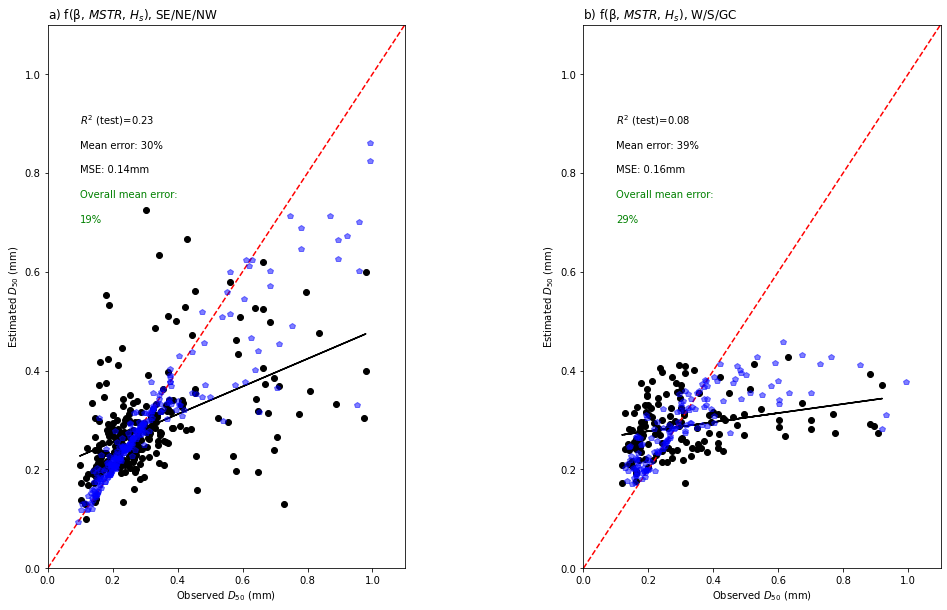

In [703]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [df1, df2])):
    plt.subplot(1,2,counter+1)
    
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/Oz_d50-model8-skill-merged-regions.jpg', dpi=300, bbox_inches='tight')
                        


In [ ]:
### models by tide

In [704]:
len(dfOz)

809

In [705]:
XOz = pg.pairwise_corr(dfOz[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [706]:
df_micro = dfOz[dfOz['mstr']<2].copy()
Xmicro = pg.pairwise_corr(df_micro[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [707]:
df_meso = dfOz[(dfOz['mstr']>=2) & (dfOz['mstr']<4)].copy()
Xmeso = pg.pairwise_corr(df_meso[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [708]:
df_macro = dfOz[dfOz['mstr']>4].copy()
Xmacro = pg.pairwise_corr(df_macro[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

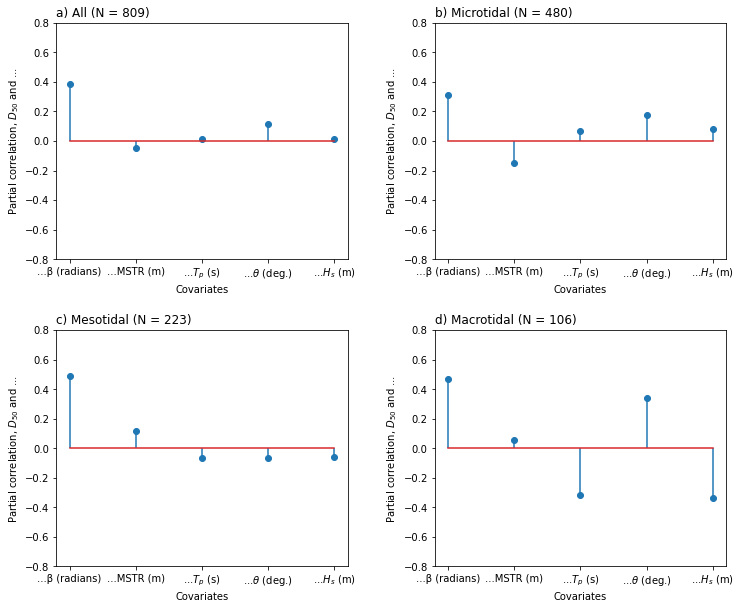

In [709]:
plt.figure(figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#=================================
ax=plt.subplot(221)
plt.stem(XOz['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"a) All (N = {})".format(len(dfOz)), loc='left')

#=================================
ax=plt.subplot(222)
plt.stem(Xmicro['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"b) Microtidal (N = {})".format(len(df_micro)), loc='left')

#=================================
ax=plt.subplot(223)
plt.stem(Xmeso['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"c) Mesotidal (N = {})".format(len(df_meso)), loc='left')

#=================================
ax=plt.subplot(224)
plt.stem(Xmacro['r'])
# plt.stem(lower)
# plt.stem(upper)
plt.xticks([0,1,2,3,4])
ax.set_xticklabels(['...β (radians)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
plt.ylim(-.8,.8)
plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
plt.xlabel(r'Covariates')
plt.title(r"d) Macrotidal (N = {})".format(len(df_macro)), loc='left')

plt.savefig('../data_plots/partial-correl-Aus-tides.jpg', dpi=300, bbox_inches='tight')

In [710]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [711]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']

for counter, df in enumerate([df_micro, df_meso, df_macro]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    # model8 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


model:0
0.99309
0.93303
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0178
Mean RMSE: 0.127 (0.041)
model:1
0.95926
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0348
Mean RMSE: 0.174 (0.052)
model:2
0.97942
0.95926
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0396
Mean RMSE: 0.221 (0.087)


In [712]:
np.save('../model_out/dataset_Aus_microtidal_model8.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_Aus_mesotidal_model8.npy', MODELS[1], allow_pickle=True)
np.save('../model_out/dataset_Aus_macrotidal_model8.npy', MODELS[2], allow_pickle=True)


In [713]:
regions = ['Microtidal', 'Mesotidal', 'Macrotidal']

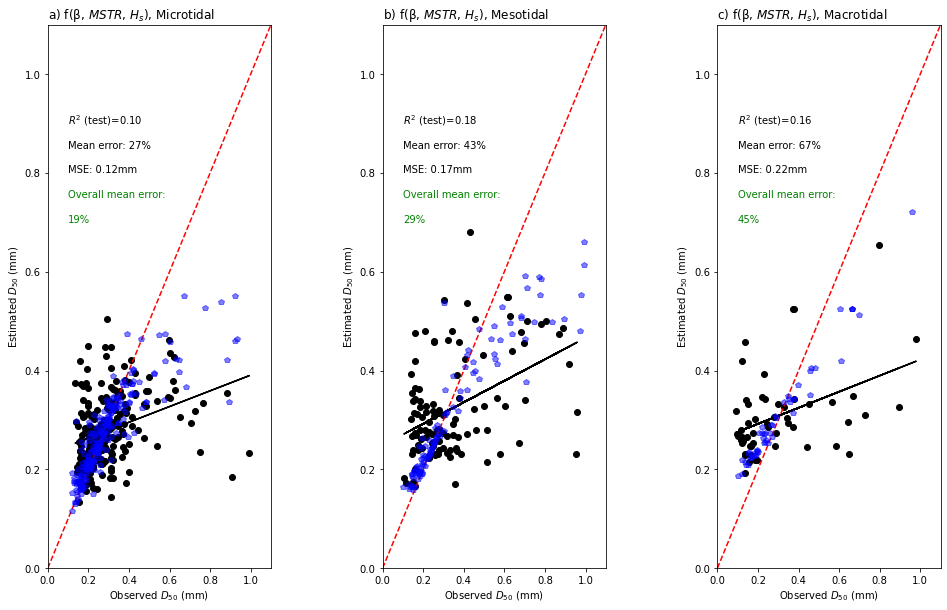

In [715]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [df_micro, df_meso, df_macro])):
    plt.subplot(1,3,counter+1)
    
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/Oz_d50-model8-skill-tides.jpg', dpi=300, bbox_inches='tight')
                        


In [718]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [719]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']

for counter, df in enumerate([df_micro, df_meso, df_macro]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['hs_mean'], rand))
    X.shape

    X_train5, X_test5, y_train5, y_test5= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test5.max())
    print(y_train5.max())

    # model5 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model5.fit(X_train5, y_train5)

    mse8 = mean_squared_error(y_test5,model5.predict(X_test5))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))
    
    model5out = {}
    model5out['feature_names'] = feature_names5
    model5out['Xtest'] = X_test5
    model5out['Xtrain'] = X_train5
    model5out['ytest'] = y_test5
    model5out['ytrain'] = y_train5
    model5out['model'] = model5
    model5out['mse'] = mse5
    model5out['best_params'] = model5.best_params_
    
    model5 = model5.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model5out)
    BEST_MODELS.append(model5)


model:0
0.99309
0.93303
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.131 (0.043)
model:1
0.95926
0.99309
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.177 (0.043)
model:2
0.97942
0.95926
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0076
Mean RMSE: 0.212 (0.093)


In [720]:
np.save('../model_out/dataset_Aus_microtidal_model5.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_Aus_mesotidal_model5.npy', MODELS[1], allow_pickle=True)
np.save('../model_out/dataset_Aus_macrotidal_model5.npy', MODELS[2], allow_pickle=True)


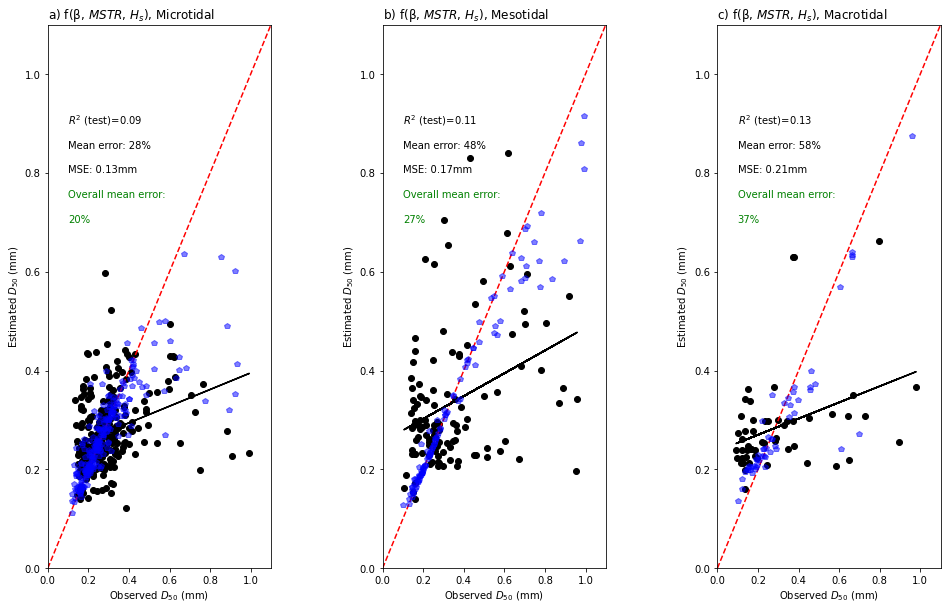

In [721]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [df_micro, df_meso, df_macro])):
    plt.subplot(1,3,counter+1)
    
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['hs_mean'], rand))
    X.shape

    X_train5, X_test5, y_train5, y_test5= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test5)
    plt.plot(y_test5, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test5, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test5, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test5, poly1d_fn(y_test5), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train5)
    plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/Oz_d50-model5-skill-tides.jpg', dpi=300, bbox_inches='tight')
                        


In [ ]:
## combined Aus, SEUS , divied by tide

In [809]:
df_merged = pd.concat([dfSEUS, dfOz], ignore_index=True)
df_micro = df_merged[df_merged['mstr']<2].copy()
Xmicro = pg.pairwise_corr(df_micro[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

df_meso = df_merged[(df_merged['mstr']>=2) & (df_merged['mstr']<4)].copy()
Xmeso = pg.pairwise_corr(df_meso[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

df_macro = df_merged[df_merged['mstr']>=4].copy()
Xmacro = pg.pairwise_corr(df_macro[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)


In [810]:
print(len(df_micro))
print(len(df_meso))
print(len(df_macro))

685
288
106


In [811]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [812]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']

for counter, df in enumerate([df_micro, df_meso, df_macro]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    # model8 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


model:0
1.00996914622761
1.00996914622761
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0192
Mean RMSE: 0.158 (0.037)
model:1
0.99309
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0416
Mean RMSE: 0.199 (0.044)
model:2
0.97942
0.95926
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0418
Mean RMSE: 0.206 (0.086)


In [814]:
regions = ['Microtidal', 'Mesotidal', 'Macrotidal']

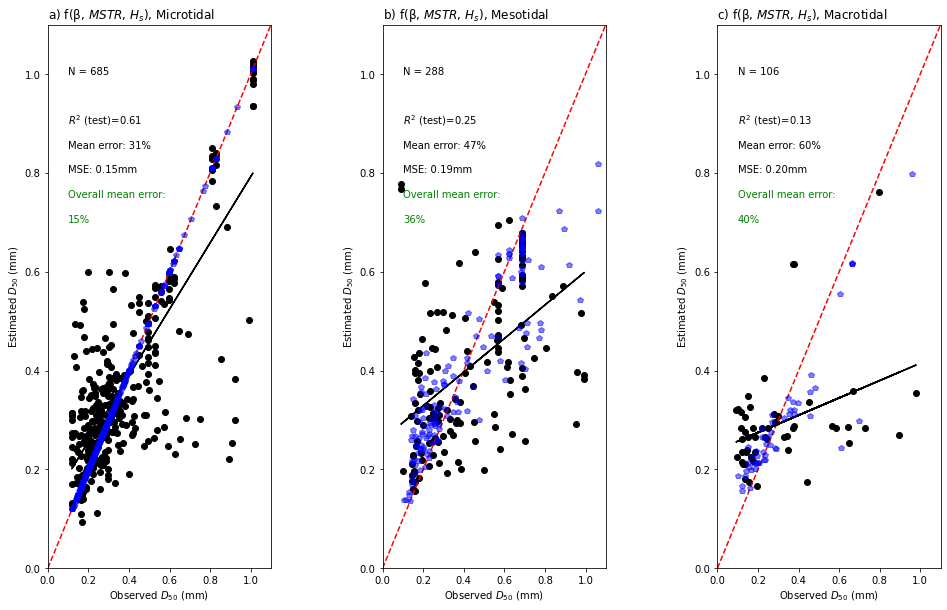

In [817]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [df_micro, df_meso, df_macro])):
    plt.subplot(1,3,counter+1)
    
    filename = '../model_out/Oztides'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])
    plt.text(xanchor,yanchor+.1,r'N = {}'.format(len(df)))

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/SEUS_plus_Oz_d50-model8-skill-tides.jpg', dpi=300, bbox_inches='tight')
                        


In [722]:
# len(dfOz)

In [ ]:
## combine SEUS and Aus regions

In [723]:
df1 = pd.concat([dfSEUS, dfOzNW, dfOzNE, dfOzSE], ignore_index=True)
df2 = pd.concat([dfSEUS, dfOzS, dfOzW, dfOzCG], ignore_index=True)
df3 = pd.concat([dfSEUS, dfOz], ignore_index=True)

In [725]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [726]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']

for counter, df in enumerate([df1, df2, df3]):
    print("model:{}".format(counter))
    
    rand = np.random.randn(len(df))
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    np.save(filename, rand, allow_pickle=True)
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    # model8 = ensemble.GradientBoostingRegressor(**params)
    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


model:0
1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0225
Mean RMSE: 0.154 (0.027)
model:1
1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0196
Mean RMSE: 0.150 (0.032)
model:2
1.06082628750927
1.06082628750927
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0273
Mean RMSE: 0.169 (0.023)


In [727]:
np.save('../model_out/dataset_SEUS_plus_Aus_NW_NE_SE_coast_model8.npy', MODELS[0], allow_pickle=True)
np.save('../model_out/dataset_SEUS_plus_Aus_W_S_CG_coast_model8.npy', MODELS[1], allow_pickle=True)
np.save('../model_out/dataset_SEUS_plus_wholeAus_coast_model8.npy', MODELS[2], allow_pickle=True)

In [728]:
regions = ['SEUS/SE/NE/NW', 'SEUS/W/S/GC', 'SEUS/Aus']

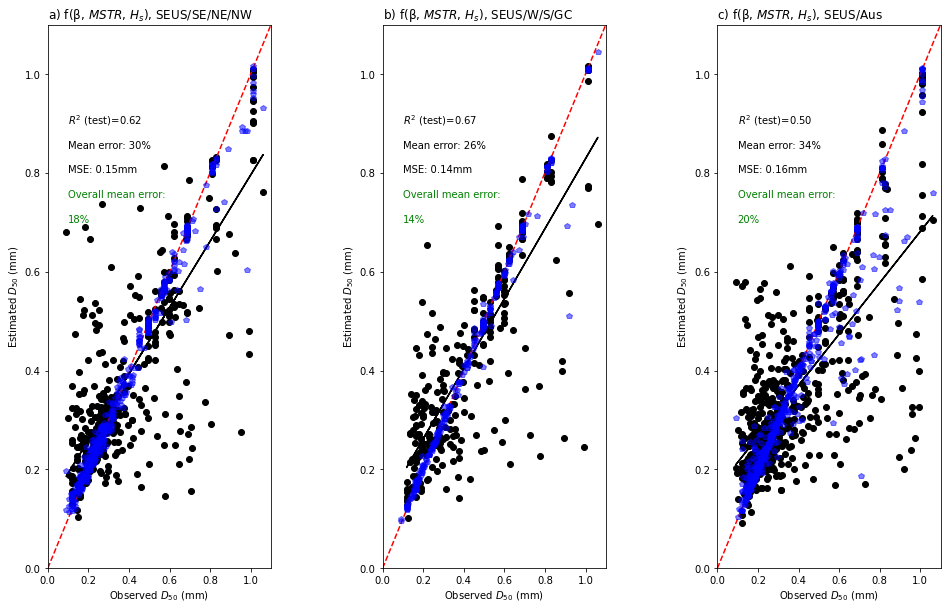

In [731]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, df) in enumerate(zip(BEST_MODELS, [df1, df2, df3])):
    plt.subplot(1,3,counter+1)
    
    filename = '../model_out/Ozregions'+str(counter)+'_rand.npy'
    rand = np.load(filename, allow_pickle=True)
    
    X = np.stack((df['beach_slope_average'], df['mstr'], df['tp'], df['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, df['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") f(β, $MSTR$, $H_s$), {}".format(regions[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/SEUS_plus_Oz_d50-model8-skill-merged-regions.jpg', dpi=300, bbox_inches='tight')
                        


In [ ]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

In [846]:
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(.4e-1, .4e9))
# gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=.1)
# gaussian_process.fit(X_train8, y_train8)
# gaussian_process.kernel_

0.307**2 * RBF(length_scale=8.64e+06)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


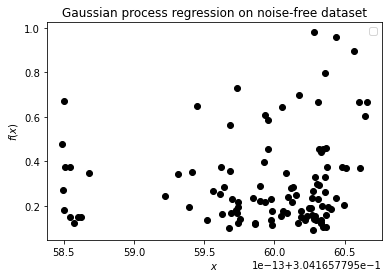

In [847]:
# mean_prediction, std_prediction = gaussian_process.predict(X.T, return_std=True)

# plt.plot(mean_prediction, df['d50'],'ko')
# # plt.scatter(X_train8, y_train8, label="Observations")
# # plt.plot(X.T, mean_prediction, label="Mean prediction")
# # plt.fill_between(
# #     X.T.ravel(),
# #     mean_prediction - 1.96 * std_prediction,
# #     mean_prediction + 1.96 * std_prediction,
# #     alpha=0.5,
# #     label=r"95% confidence interval",
# # )
# plt.legend()
# plt.xlabel("$x$")
# plt.ylabel("$f(x)$")
# _ = plt.title("Gaussian process regression on noise-free dataset")

In [848]:
# # from sklearn.datasets import make_friedman2
# # from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [850]:
# kernel = DotProduct() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train8, y_train8)
# gpr.score(X_test8, y_test8)


0.13360643098420277

In [853]:
# ds_est, ds_std = gpr.predict(X_test8, return_std=True)

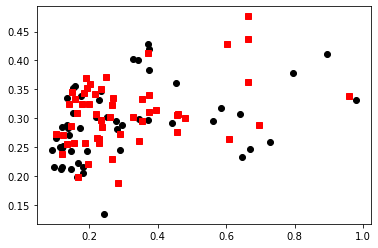

In [856]:
# plt.plot(y_test8,ds_est, 'ko')

# ds_est2, ds_std2 = gpr.predict(X_train8, return_std=True)
# plt.plot(y_train8,ds_est2, 'rs')


In [ ]:
## divisions

In [732]:
len(dfOzregions)

809

In [733]:

divisions = '../../../orig_data/australia/sediment_compartments/Divisions.geojson'
Oz_divisions = gpd.read_file(divisions)

dfOzdivisions = sjoin(dfOz, Oz_divisions, how='left')

C:\Users\dbuscombe\AppData\Local\Temp\8\ipykernel_6484\1072345722.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4283

  dfOzdivisions = sjoin(dfOz, Oz_divisions, how='left')


In [734]:
len(dfOzdivisions)

810

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23], dtype=int64)

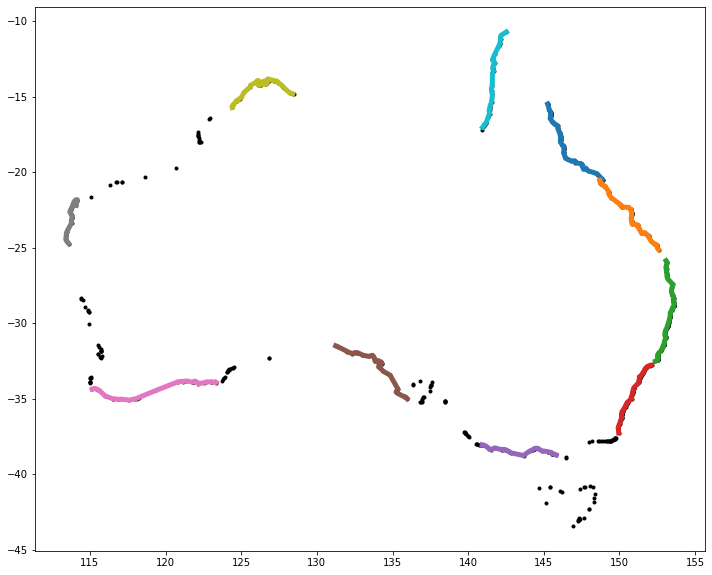

In [750]:
plt.figure(figsize=(12,10))

divisions = {}
for k in np.unique(Oz_divisions['ID_Divisio']):
    tmp = dfOzdivisions[dfOzdivisions['ID_Divisio']==k]
    plt.plot(tmp['longitude'], tmp['latitude'],'k.')

    if len(tmp)>30:
       divisions[str(k)] = tmp 
divisions.keys()

for k in divisions:
    plt.plot(divisions[k]['longitude'], divisions[k]['latitude'], lw=5)


In [752]:
tmp

'1'

In [757]:
Smean = []
Sstd = []
MODELS = []
BEST_MODELS = []

In [758]:
for counter, k in enumerate(divisions):
    tmp = divisions[k][['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()
    print(len(tmp))
    rand = np.random.randn(len(tmp))

    X = np.stack((tmp['beach_slope_average'], tmp['mstr'], tmp['tp'], tmp['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, tmp['d50'], test_size=test_size, random_state=2022
    )

    print(y_test8.max())
    print(y_train8.max())

    gbr = ensemble.GradientBoostingRegressor()#**params)

    model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
    model8.fit(X_train8, y_train8)

    mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))
    
    model8out = {}
    model8out['feature_names'] = feature_names8
    model8out['Xtest'] = X_test8
    model8out['Xtrain'] = X_train8
    model8out['ytest'] = y_test8
    model8out['ytrain'] = y_train8
    model8out['model'] = model8
    model8out['mse'] = mse8
    model8out['best_params'] = model8.best_params_
    
    model8 = model8.best_estimator_
    
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
    # evaluate model
    scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = np.absolute(scores)
    print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

    Smean.append(scores.mean())
    Sstd.append(scores.std())
    
    MODELS.append(model8out)
    BEST_MODELS.append(model8)


84
0.95926
0.97265
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0437
Mean RMSE: 0.190 (0.087)
79
0.80664
0.77378
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0148
Mean RMSE: 0.104 (0.078)
131
0.95264
0.6498
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0105
Mean RMSE: 0.074 (0.068)
117
0.5716
0.6797
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0064
Mean RMSE: 0.070 (0.027)
45
0.76844
0.70222
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.0535
Mean RMSE: 0.197 (0.091)
34
0.99309
0.8827
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
The mean squared error (MSE) on test set: 0.1326
Mean RMSE: 0.294 (0.184)
40
0.6029
0.61985
Fitting 5 folds for each of 23

[1, 2, 3, 4, 9, 12, 14, 16, 18, 23]

In [796]:
Names = [divisions[k]['Name'].values[0] for k in divisions.keys()]

In [791]:
IDs = [divisions[k]['ID_Divisio'].values[0] for k in divisions.keys()]
ids = 'abcdefghijk'

In [797]:
Names

['Eastern Cape York Peninsula',
 'Central Queensland Coast',
 'Central East Coast',
 'Southern NSW Coast',
 'Central and Western Victoria',
 'Western Eyre Peninsula',
 'Southern WA Coast',
 'Central West Coast',
 'Kimberley',
 'Western Cape York Peninsula']

84
79
131
117
45
34
40
31
47
48


C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


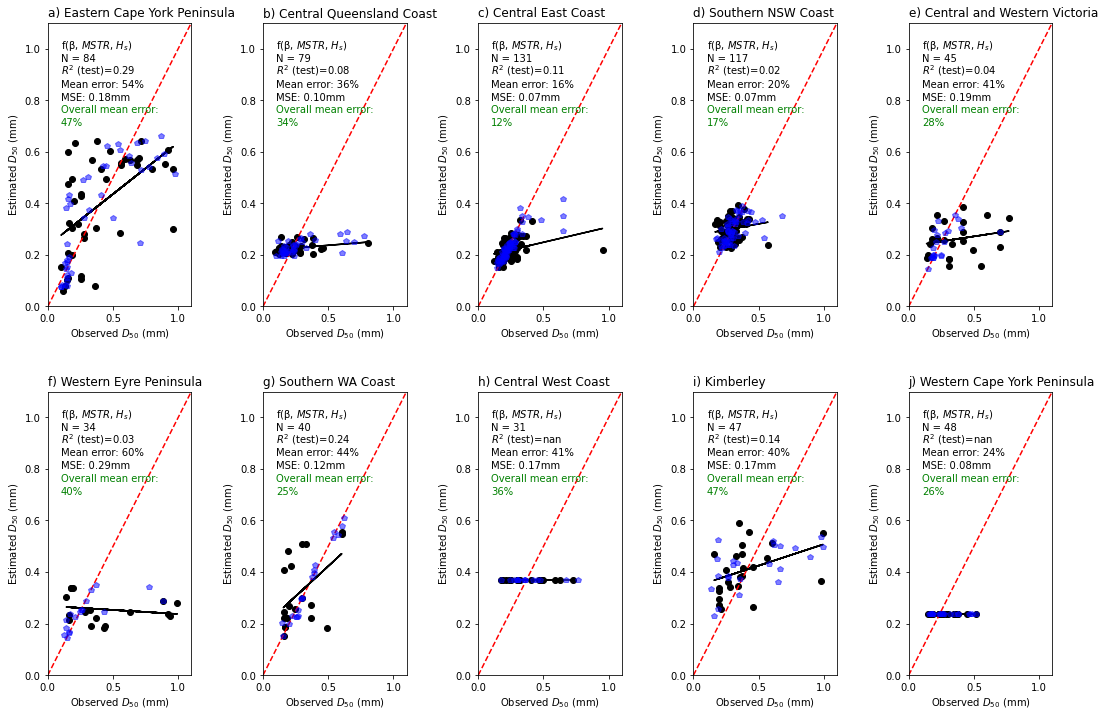

In [807]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(wspace=0.5, hspace=0.3)

xanchor = .1
yanchor = .9

for counter, (model, tmp) in enumerate(zip(BEST_MODELS, divisions)):
    plt.subplot(2,5,counter+1)
    
    tmp = divisions[tmp][['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()
    print(len(tmp))
    rand = np.random.randn(len(tmp))
    
    X = np.stack((tmp['beach_slope_average'], tmp['mstr'], tmp['tp'], tmp['hs_mean'],  rand))
    X.shape

    X_train8, X_test8, y_train8, y_test8= train_test_split(
        X.T, tmp['d50'], test_size=test_size, random_state=2022
    )    
                                      
    ds_est = model.predict(X_test8)
    plt.plot(y_test8, ds_est, 'ko')
    plt.xlim(0,1.1); plt.ylim(0,1.1)
    yl=plt.ylim()
    plt.plot(yl,yl,'--r')
    plt.xlabel(r'Observed $D_{50}$ (mm)')
    plt.ylabel(r'Estimated $D_{50}$ (mm)')
    plt.title(ids[counter]+r") {}".format(Names[counter]), loc='left')
    r2 = np.min(np.corrcoef(y_test8, ds_est))**2
    plt.text(xanchor,yanchor,r'$R^2$ (test)='+str(r2)[:4])
    plt.text(0.1,1,r'f(β, $MSTR$, $H_s$)' )
    plt.text(0.1,.95,r'N = {}'.format(len(tmp)) )

    coef = np.polyfit(y_test8, ds_est,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(y_test8, poly1d_fn(y_test8), '-k')
    plt.text(xanchor,yanchor-.05, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
    plt.text(xanchor,yanchor-.1, r'MSE: {}mm'.format(str(Smean[counter])[:4]))

    ds_est2 = model.predict(X_train8)
    plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

    plt.text(xanchor,yanchor-.15, r'Overall mean error:', color='g')
    plt.text(xanchor,yanchor-.2, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.savefig('../model_plots/SEUS_plus_Oz_d50-model8-skill-merged-divisions.jpg', dpi=300, bbox_inches='tight')
                        


In [618]:
# X = pg.pairwise_corr(df[['beach_slope_average','d50','mstr','tp','dir','hs_mean']].copy(), columns=['d50'], method='spearman', alternative='greater', padjust='bonf').round(3)

In [226]:
# plt.figure(figsize=(14,14))
# plt.subplots_adjust(wspace=0.3, hspace=0.3)

# #=================================
# # plt.subplot(331)
# plt.subplot(321)
# plt.plot(df['beach_slope_average'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko', label='Mesotidal')
# plt.plot(df['beach_slope_average'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.', label='Microtidal')

# coef = np.polyfit(df['beach_slope_average'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['beach_slope_average'][df['mstr']>=1], poly1d_fn(df['beach_slope_average'][df['mstr']>=1]), '-k')

# coef = np.polyfit(df['beach_slope_average'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(df['beach_slope_average'][df['mstr']<1]), poly1d_fn(sorted(df['beach_slope_average'][df['mstr']<1])), '--r')

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['beach_slope_average'][df['mstr']>=1]))**2
# plt.text(.02,1,r'$R^2$='+str(r2)[:4])

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['beach_slope_average'][df['mstr']<1]))**2
# plt.text(.02,.9,r'$R^2$='+str(r2)[:4], color='r')

# plt.ylabel(r'$H_s$ (m)')
# plt.xlabel(r'tan β (radians)')
# plt.title(r"a)", loc='left')
# plt.legend()

# #================================
# # plt.subplot(332)
# plt.subplot(322)
# plt.plot(df['mstr'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
# plt.plot(df['mstr'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

# coef = np.polyfit(df['mstr'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['mstr'][df['mstr']>=1], poly1d_fn(df['mstr'][df['mstr']>=1]), '-k')

# coef = np.polyfit(df['mstr'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(df['mstr'][df['mstr']<1]), poly1d_fn(sorted(df['mstr'][df['mstr']<1])), '--r')

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['mstr'][df['mstr']>=1]))**2
# plt.text(1.5,1,r'$R^2$='+str(r2)[:4])

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['mstr'][df['mstr']<1]))**2
# plt.text(1.5,.9,r'$R^2$='+str(r2)[:4], color='r')

# plt.ylabel(r'$H_s$ (m)')
# plt.xlabel(r'MSTR (m)')
# plt.title(r"b)", loc='left')

# #=================================
# # plt.subplot(334)
# plt.subplot(323)
# plt.plot(df['tp'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
# plt.plot(df['tp'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

# coef = np.polyfit(df['tp'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['tp'][df['mstr']>=1], poly1d_fn(df['tp'][df['mstr']>=1]), '-k')

# coef = np.polyfit(df['tp'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(df['tp'][df['mstr']<1]), poly1d_fn(sorted(df['tp'][df['mstr']<1])), '--r')

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['tp'][df['mstr']>=1]))**2
# plt.text(4,1,r'$R^2$='+str(r2)[:4])

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['tp'][df['mstr']<1]))**2
# plt.text(4,.9,r'$R^2$='+str(r2)[:4], color='r')

# plt.ylabel(r'$H_s$ (m)')
# plt.xlabel(r'$T_p$ (s)')
# plt.title(r"c)", loc='left')

# #=================================
# # plt.subplot(335)
# plt.subplot(324)
# plt.plot(df['dir'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],'ko')
# plt.plot(df['dir'][df['mstr']<1],df['hs_mean'][df['mstr']<1],'r.')

# coef = np.polyfit(df['dir'][df['mstr']>=1],df['hs_mean'][df['mstr']>=1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['dir'][df['mstr']>=1], poly1d_fn(df['dir'][df['mstr']>=1]), '-k')

# coef = np.polyfit(df['dir'][df['mstr']<1],df['hs_mean'][df['mstr']<1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(df['dir'][df['mstr']<1]), poly1d_fn(sorted(df['dir'][df['mstr']<1])), '--r')

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']>=1], df['dir'][df['mstr']>=1]))**2
# plt.text(80,1,r'$R^2$='+str(r2)[:4])

# r2 = np.min(np.corrcoef(df['hs_mean'][df['mstr']<1], df['dir'][df['mstr']<1]))**2
# plt.text(120,1,r'$R^2$=0.0', color='r') #+str(r2)[:4]

# plt.ylabel(r'$H_s$ (m)')
# plt.xlabel(r'$\theta$ (deg.)')
# plt.title(r"d)", loc='left')

# #=================================
# # plt.subplot(233)
# plt.subplot(325)
# plt.plot(df['mstr'][df['mstr']>=1],df['beach_slope_average'][df['mstr']>=1],'ko')
# plt.plot(df['mstr'][df['mstr']<1],df['beach_slope_average'][df['mstr']<1],'r.')

# coef = np.polyfit(df['mstr'][df['mstr']>=1],df['beach_slope_average'][df['mstr']>=1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(df['mstr'][df['mstr']>=1], poly1d_fn(df['mstr'][df['mstr']>=1]), '-k')

# coef = np.polyfit(df['mstr'][df['mstr']<1],df['beach_slope_average'][df['mstr']<1],1)
# poly1d_fn = np.poly1d(coef) 
# plt.plot(sorted(df['mstr'][df['mstr']<1]), poly1d_fn(sorted(df['mstr'][df['mstr']<1])), '--r')

# r2 = np.min(np.corrcoef(df['beach_slope_average'][df['mstr']>=1], df['mstr'][df['mstr']>=1]))**2
# plt.text(1,0.02,r'$R^2$='+str(.1+r2)[:4])

# r2 = np.min(np.corrcoef(df['beach_slope_average'][df['mstr']<1], df['mstr'][df['mstr']<1]))**2
# plt.text(1,0.01,r'$R^2$='+str(r2)[:4], color='r')

# plt.ylabel(r'tan β (radians)')
# plt.xlabel(r'MSTR (m)')
# plt.title(r"e)", loc='left')

# #=================================
# ax=plt.subplot(326)
# plt.stem(X['r'])
# # plt.stem(lower)
# # plt.stem(upper)
# plt.xticks([0,1,2,3,4])
# ax.set_xticklabels(['...β (radians)', '...MSTR (m)',r'...$T_p$ (s)',r'...$\theta$ (deg.)',r'...$H_s$ (m)'])
# plt.ylim(-.8,.8)
# plt.ylabel(r'Partial correlation, $D_{50}$ and ...')
# plt.xlabel(r'Covariates')
# plt.title(r"f)", loc='left')

# # plt.savefig('../data_plots/multicol_plus_partial_correl-strat-lat.jpg', dpi=300, bbox_inches='tight')